# Importing Libraries

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from dateutil.parser import parse
import pandasql as ps
import shutil

from sklearn.cluster import KMeans
from collections import Counter
import scipy
from prophet import Prophet
from prophet.plot import plot_plotly,plot_components_plotly
import researchpy as rp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from patsy import dmatrices

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

bo = ["#6930c3","#5e60ce","#0096c7","#48cae4","#ade8f4","#ff7f51","#ff9b54","#ffbf69"]

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

# Exploration & Cleaning of Data Sets

In [ ]:
data_df=pd.read_csv("C:\\Users\\Stats machine learning\\StatsProject\\wanderjaunt\\data\\scraped_data\\scraped_data.csv")
data_listing=pd.read_csv("C:\\Stats machine learning\\StatsProject\\wanderjaunt\\data\\scraped_data\\scraped_listings.csv",encoding='cp1252')

## Exploring Scraped Data 

In [ ]:
data_df.head()

,scraping_id,scraped_date,date,price,available
0,2,2018-03-15,2018-04-01,250,1
1,2,2018-03-15,2018-04-02,115,1
2,2,2018-03-15,2018-04-03,115,1
3,2,2018-03-15,2018-04-04,115,1
4,2,2018-03-15,2018-04-05,150,0


In [ ]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
scraping_id,16300175.0,8.859516e+06,1.058208e+07,2.0,3835.0,12939.0,21473085.0,24707544.0
price,16300175.0,3.068724e+02,8.637483e+02,10.0,100.0,159.0,300.0,25000.0
available,16300175.0,4.880770e-01,4.998578e-01,0.0,0.0,0.0,1.0,1.0


We can see there is outlier in the price column.

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16300175 entries, 0 to 16300174
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   scraping_id   int64 
 1   scraped_date  object
 2   date          object
 3   price         int64 
 4   available     int64 
dtypes: int64(3), object(2)
memory usage: 621.8+ MB


In [ ]:
data_df.isna().sum()

scraping_id     0
scraped_date    0
date            0
price           0
available       0
dtype: int64

There are no null value in the dataset

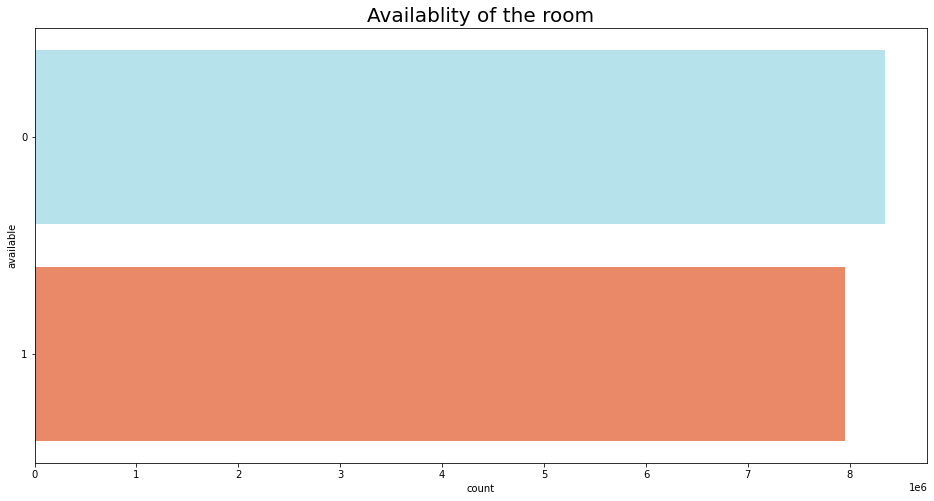

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Availablity of the room', size = 20)
sns.countplot(y ='available', data = data_df,palette=bo[4:]);

We have a balanced dataset

<AxesSubplot:xlabel='available', ylabel='price'>

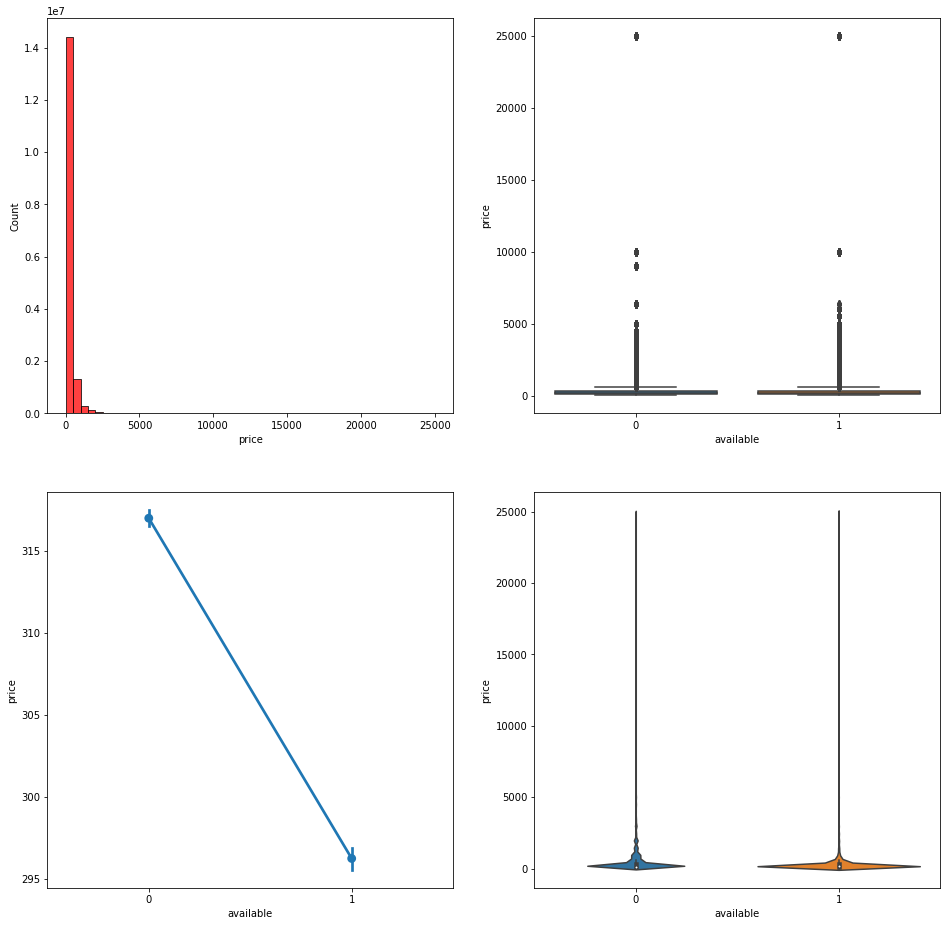

In [ ]:
fig,ax = plt.subplots(2,2,figsize = (16,16))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.histplot(data_df['price'],bins=50,color='r',ax=ax1)
sns.boxplot(y='price',x='available',data=data_df,ax=ax2)
sns.pointplot(y='price',x='available',data=data_df,ax=ax3)
sns.violinplot(y='price',x='available',data=data_df,ax=ax4)

the price column is right skewed, there are presence of outliers in this column which is evidant from the boxplot.

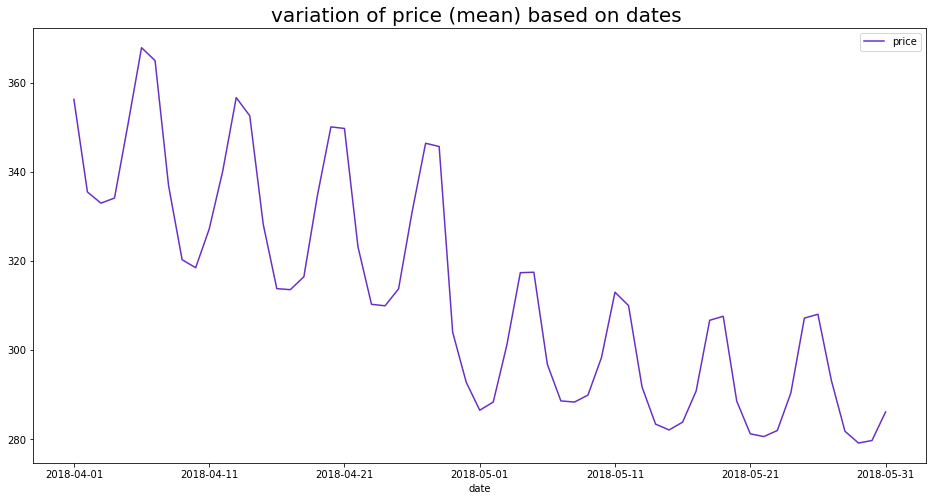

In [ ]:
data_dates = data_df.groupby('date')['date','price'].mean()
data_dates.plot(figsize=(16,8),color=bo[0])
plt.title('variation of price (mean) based on dates ', size = 20)
plt.show()

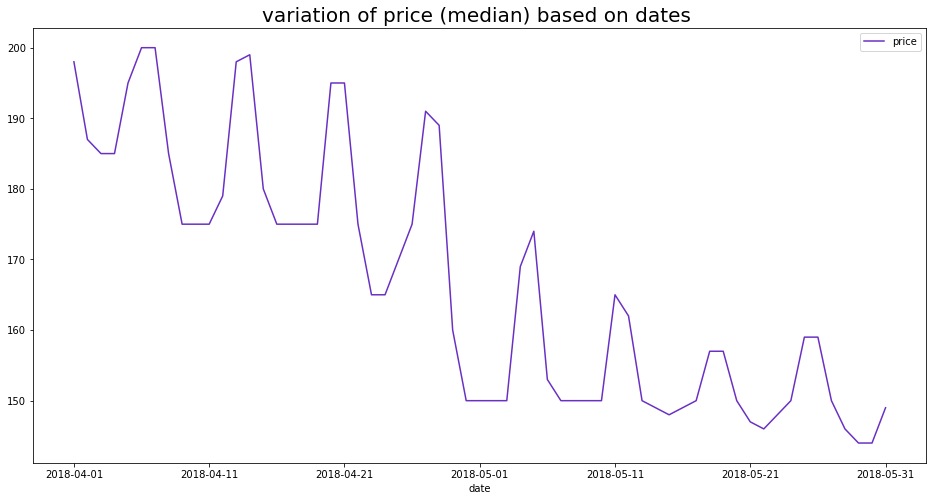

In [ ]:
data_dates = data_df.groupby('date')['date','price'].median()
data_dates.plot(figsize=(16,8),color=bo[0])
plt.title('variation of price (median) based on dates ', size = 20)
plt.show()

We have the data for the hotels rooms, for the nonths of April and May, we can find that there is a decrease in the avg and median of the prices as the dates move from april to may. Checking the mean price of the hotel, its over 360$ in the beginning of the april and then gradually decrease to well below 300 in may. Since we have observed outliers in the data, to make sure this trend exists in the data, we also plotted variation of median of prices, and we can verify it does decrease.

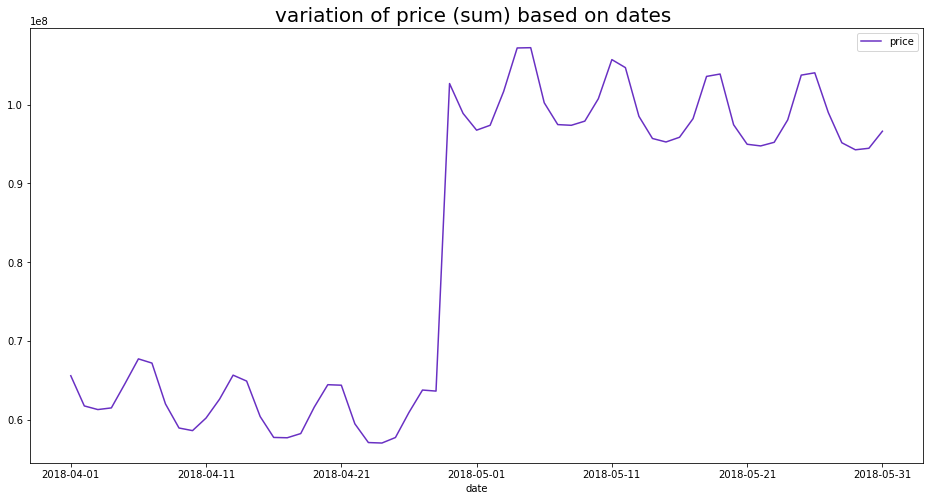

In [ ]:
data_dates = data_df.groupby('date')['date','price'].sum()
data_dates.plot(figsize=(16,8),color=bo[0])
plt.title('variation of price (sum) based on dates ', size = 20)
plt.show()

The total sum of prices increase rapidly from april to may.

In [ ]:
data_df.nunique()

scraping_id     5647
scraped_date      78
date              61
price           1561
available          2
dtype: int64

There are 5647 unique ids, and these data is collected over 61 different dates.

## Exploring Scraped Listing
 

In [ ]:
data_listing.head()

,scraping_id,listing,city,lon,lat,mapped_location,name,capacity,bathrooms,bedrooms,has_pool,cleaning_fee,is_superhost,host_name
0,2,https://www.airbnb.com/rooms/17720788,Scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2,1,150,1,Mj
1,3,https://www.airbnb.com/rooms/4400911,Scottsdale,-111.898977,33.463182,https://maps.google.com/maps?q=33.463182488027...,Upscale Townhouse South Scottsdale,4,1.5,2,1,85,1,Jamil
2,4,https://www.airbnb.com/rooms/19748678,Scottsdale,-111.957684,33.607810,https://maps.google.com/maps?q=33.607809726520...,North Scottsdale/ PV Private Guest House w/pool,4,1,0,1,75,1,Julie And Bill
3,5,https://www.airbnb.com/rooms/18900365,Scottsdale,-111.915536,33.499397,https://maps.google.com/maps?q=33.499396773678...,Mountain View Paradise*Heated Pool*Spa*Gym,4,1,1,1,100,1,Vanessa
4,6,https://www.airbnb.com/rooms/15808110,Scottsdale,-111.910657,33.490571,https://maps.google.com/maps?q=33.490570685645...,Modern Luxury Scottsdale Condo!,5,1,2,1,150,1,Sara


In [ ]:
data_listing.nunique()

scraping_id        8445
listing            8445
city                 53
lon                8445
lat                8445
mapped_location    8445
name               8296
capacity             24
bathrooms            22
bedrooms             13
has_pool              2
cleaning_fee        303
is_superhost          2
host_name          2200
dtype: int64

In [ ]:
data_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8445 entries, 0 to 8444
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   scraping_id      8445 non-null   int64  
 1   listing          8445 non-null   object 
 2   city             8445 non-null   object 
 3   lon              8445 non-null   float64
 4   lat              8445 non-null   float64
 5   mapped_location  8445 non-null   object 
 6   name             8445 non-null   object 
 7   capacity         8445 non-null   int64  
 8   bathrooms        8445 non-null   object 
 9   bedrooms         8445 non-null   object 
 10  has_pool         8445 non-null   int64  
 11  cleaning_fee     8445 non-null   object 
 12  is_superhost     8445 non-null   int64  
 13  host_name        8445 non-null   object 
dtypes: float64(2), int64(4), object(8)
memory usage: 923.8+ KB


There are 8445 unique scarping ids, which indicates that we have information about 8445 hotels in the Phoenix area. 

In [ ]:
data_listing.describe().T

,count,mean,std,min,25%,50%,75%,max
scraping_id,8445.0,1.022693e+07,1.086948e+07,2.000000,5753.000000,14871.000000,2.188136e+07,2.470754e+07
lon,8445.0,-1.119671e+02,1.679022e-01,-112.712487,-112.052714,-111.935227,-1.118972e+02,-1.113677e+02
lat,8445.0,3.351072e+01,1.339154e-01,32.840029,33.450837,33.501307,3.360120e+01,3.407657e+01
capacity,8445.0,6.053641e+00,3.282324e+00,1.000000,4.000000,6.000000,8.000000e+00,2.600000e+01
has_pool,8445.0,7.308467e-01,4.435461e-01,0.000000,0.000000,1.000000,1.000000e+00,1.000000e+00
is_superhost,8445.0,2.414446e-01,4.279846e-01,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00


Apart from the scarping id, we have 5 numerical data each indicating features about the housing.

<AxesSubplot:title={'center':'Pool Availablity in the property'}, xlabel='count', ylabel='has_pool'>

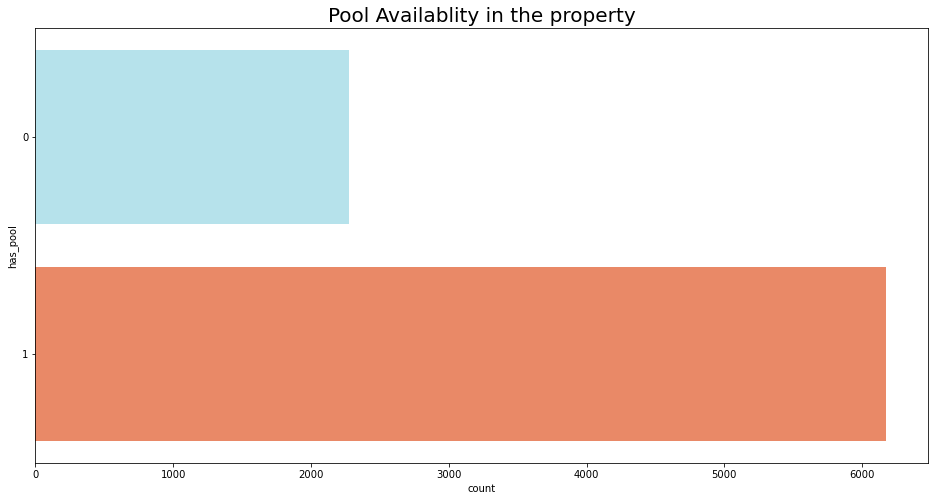

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Pool Availablity in the property', size = 20)
sns.countplot(y ='has_pool', data = data_listing,palette=bo[4:])

Out of 8445 properties, above 6000 properties has pool amenities in them.

<AxesSubplot:title={'center':'Number of Superhosts'}, xlabel='count', ylabel='is_superhost'>

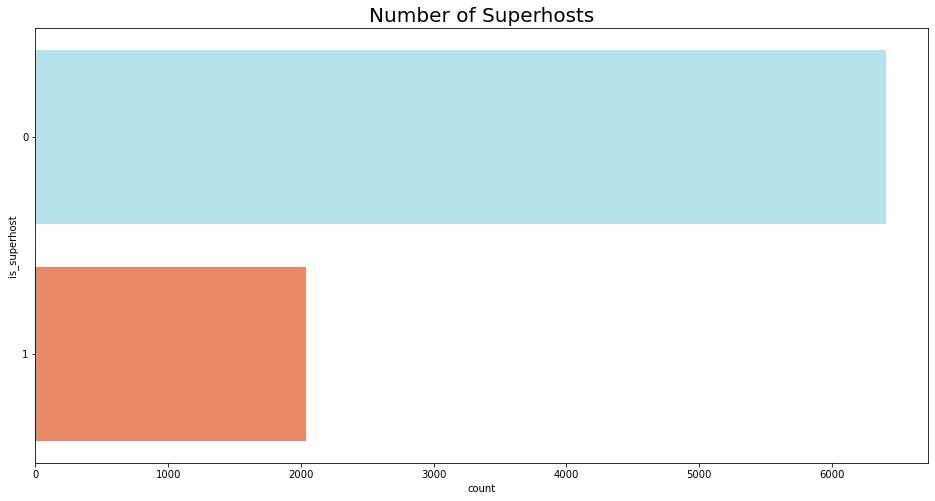

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Number of Superhosts', size = 20)
sns.countplot(y ='is_superhost', data = data_listing,palette=bo[4:])

Approximately, around 2000 super host are present in the dataset.

<AxesSubplot:title={'center':'Capacity in the property'}, xlabel='count', ylabel='capacity'>

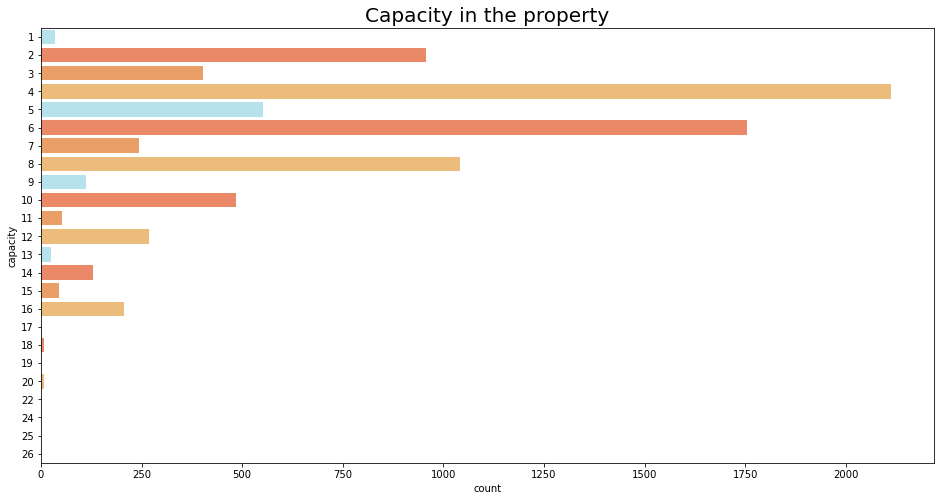

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Capacity in the property', size = 20)
sns.countplot(y ='capacity', data = data_listing,palette=bo[4:])

In [ ]:
mapping={'scottsdale':'scottsdale', 'phoenix':'phoenix', 'tempe':'tempe', 'paradise valley':'paradise valley', 'mesa':'mesa',
       'gilbert':'gilbert', 'glendale':'glendale', 'maricopa county':'maricopa', 'chandler':'chandler',
       'fountain hills':'fountain hills', 'peoria':'peoria', 'cave creek':'cave creek', 'tolleson':'tolleson', 'avondale':'avondale',
       'litchfield park':'litchfield park', 'laveen':'laveen', 'san tan valley':'san tan valley', 'surprise':'surprise',
       'queen creek':'queen creek', 'goodyear':'goodyear', 'sun city':'sun city', 'sun city west':'sun city',
       'rio verde':'rio verde', 'maricopa':'maricopa', 'anthem':'anthem', 'gold canyon':'gold canyon', 'new river':'new river',
       'apache junction':'apache junction', 'sun lakes':'sun lakes', 'carefree':'carefree', 'old town scottsdale ':'scottsdale',
       'el mirage':'el mirage', 'phoenix  ':'phoenix', 'buckeye':'buckeye', 'waddell':'waddell', 'casa grande':'casa grande',
       'new river ':'new river', 'morristown':'morristown', 'scottsdale ':'scottsdale', 'fort mcdowell':'fort mcdowell',
       'flagstaff':'flagstaff', 'phoenix ':'phoenix', 'downtown phoenix':'phoenix', 'florence':'florence',
       'surprise, arizona, us':'surprise', '??':'unkown', 'black canyon city':'black canyon city', 'wittmann':'wittmann',
       'coolidge':'coolidge', 'youngtown':'youngtown'}
data_listing['city']=data_listing['city'].apply(lambda x: (x).lower())
data_listing['city']=data_listing['city'].map(mapping)

<AxesSubplot:title={'center':'Citites of the property'}, xlabel='count', ylabel='city'>

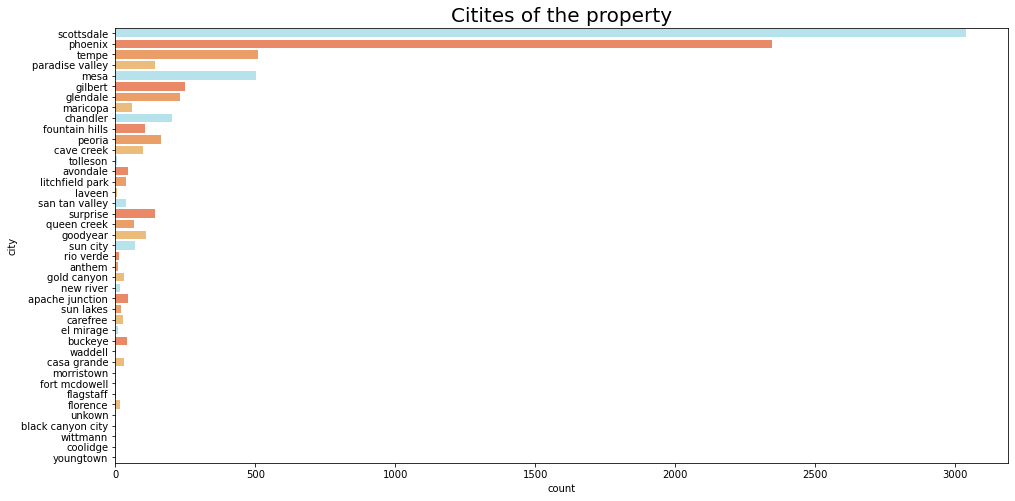

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Citites of the property', size = 20)
sns.countplot(y ='city', data = data_listing,palette=bo[4:])

<AxesSubplot:title={'center':'bathrooms in the property'}, xlabel='count', ylabel='bathrooms'>

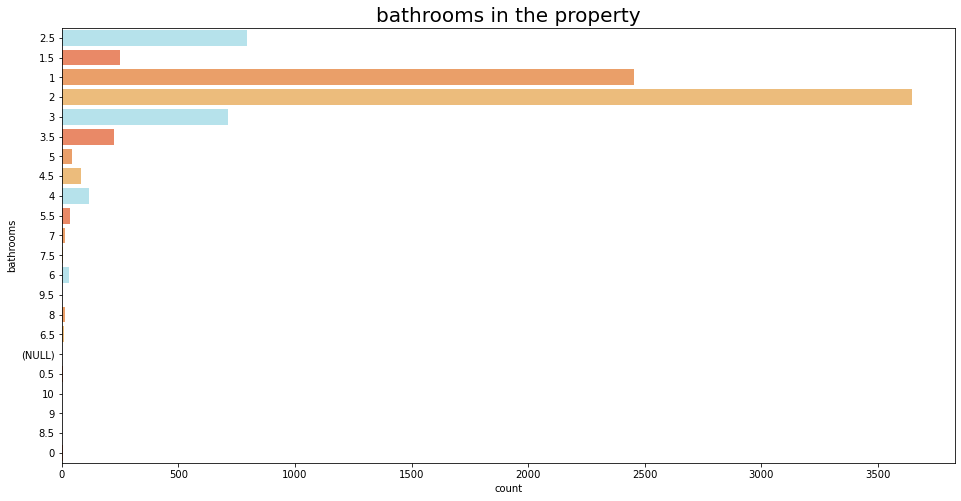

In [ ]:
plt.figure(figsize = (16,8))
plt.title('bathrooms in the property', size = 20)
sns.countplot(y ='bathrooms', data = data_listing,palette=bo[4:])

<AxesSubplot:title={'center':'Bedrooms in the property'}, xlabel='count', ylabel='bedrooms'>

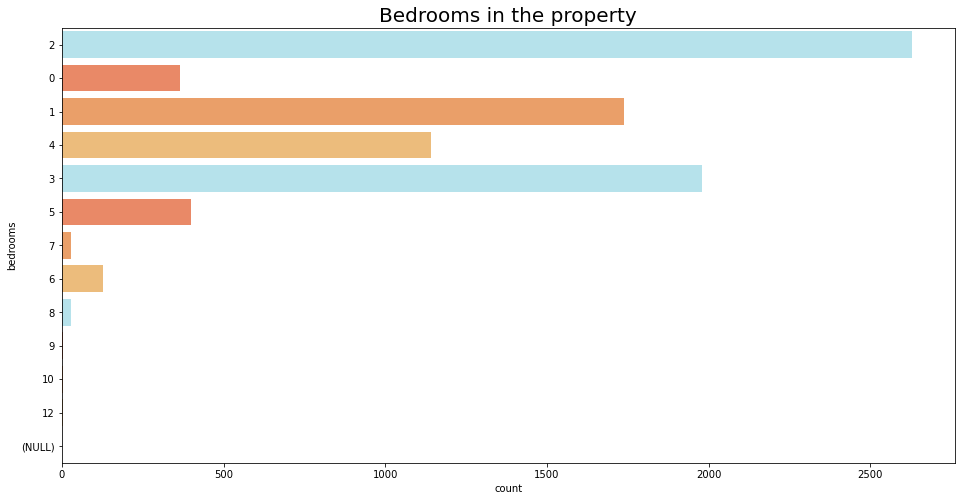

In [ ]:
plt.figure(figsize = (16,8))
plt.title('Bedrooms in the property', size = 20)
sns.countplot(y ='bedrooms', data = data_listing,palette=bo[4:])

We see there is null in the number of bedroom, we need to handle this in the feature engineering

In [ ]:
data_listing['cleaning_fee']=np.where(data_listing['cleaning_fee']=='(NULL)',0,data_listing['cleaning_fee'])
data_listing['cleaning_fee']=data_listing['cleaning_fee'].astype(float)

Text(0.5, 1.0, 'Distribution of Cleaning Fees')

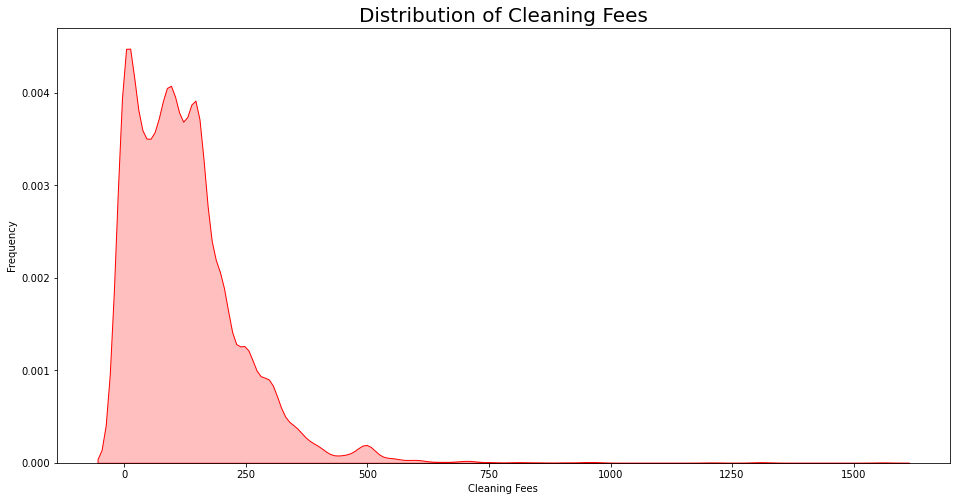

In [ ]:
plt.figure(figsize = (16,8))
g=sns.kdeplot(data_listing['cleaning_fee'], color="Red", shade = True)
g.set_xlabel("Cleaning Fees")
g.set_ylabel("Frequency")
plt.title('Distribution of Cleaning Fees',size = 20)

Cleaning fee is right skewed, as we observed in the pricing of the property

Text(0.5, 1.0, 'Box plot of Cleaning Fees')

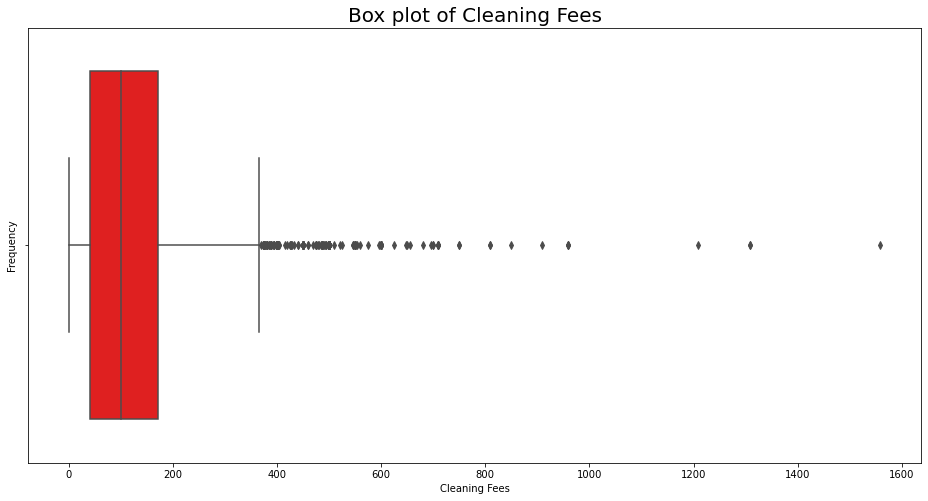

In [ ]:
plt.figure(figsize = (16,8))
g=sns.boxplot(data_listing['cleaning_fee'], color="Red")
g.set_xlabel("Cleaning Fees")
g.set_ylabel("Frequency")
plt.title('Box plot of Cleaning Fees',size = 20)

There are outliers in the cleaning fees column, similar to the trend observed in the price of the property.

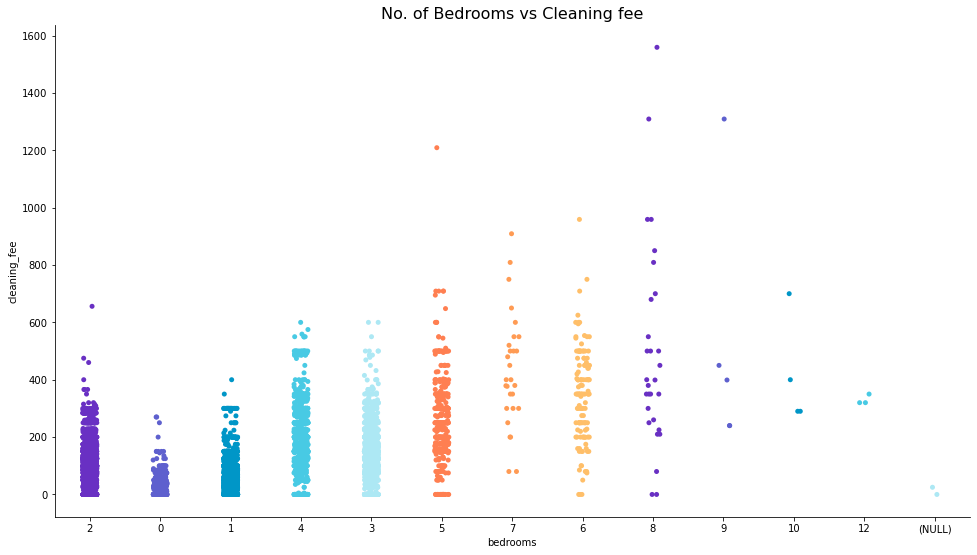

In [ ]:
sns.catplot(x="bedrooms", y="cleaning_fee", data=data_listing,palette = bo)
plt.title('No. of Bedrooms vs Cleaning fee',size=16)
plt.gcf().set_size_inches(16,8)
plt.show()

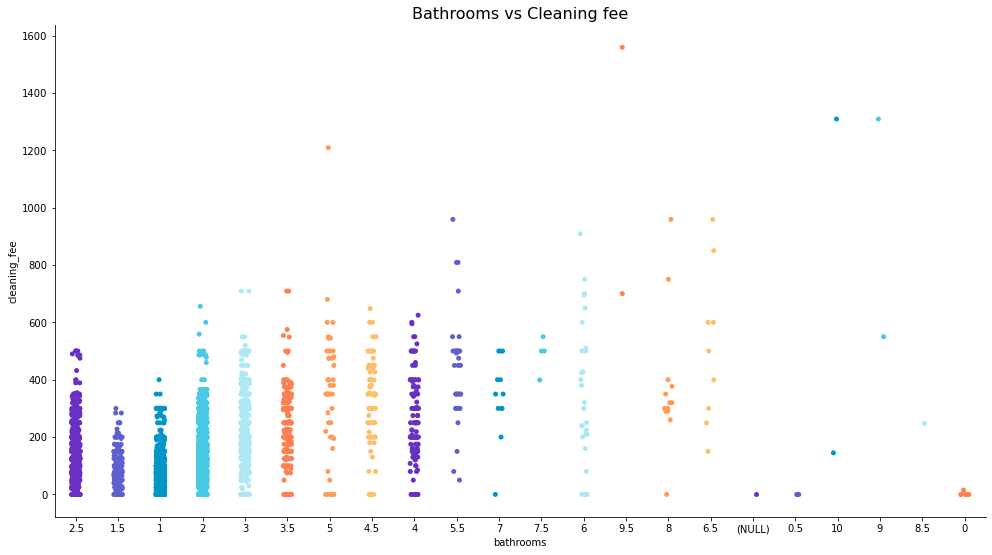

In [ ]:
sns.catplot(x="bathrooms", y="cleaning_fee", data=data_listing,palette = bo)
plt.title('Bathrooms vs Cleaning fee',size=16)
plt.gcf().set_size_inches(16,8)
plt.show()

Here we observe a trend with increase in the number of bathrooms and bedrooms hte cleaning fees are increasing linearly.

Text(0.5, 1.0, 'Box plot of Cleaning Fees')

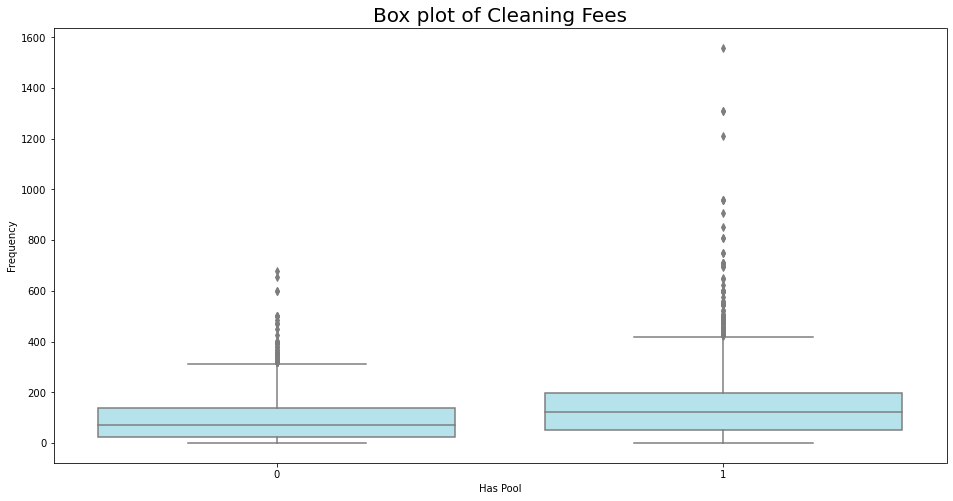

In [ ]:
plt.figure(figsize = (16,8))
g=sns.boxplot(y=data_listing['cleaning_fee'],x=data_listing['has_pool'], color=bo[4])
g.set_xlabel("Has Pool")
g.set_ylabel("Frequency")
plt.title('Box plot of Cleaning Fees',size = 20)

Cleaning fees for the properties with pool is higher than the properties without the pools.

Text(0.5, 1.0, 'Box plot of Cleaning Fees')

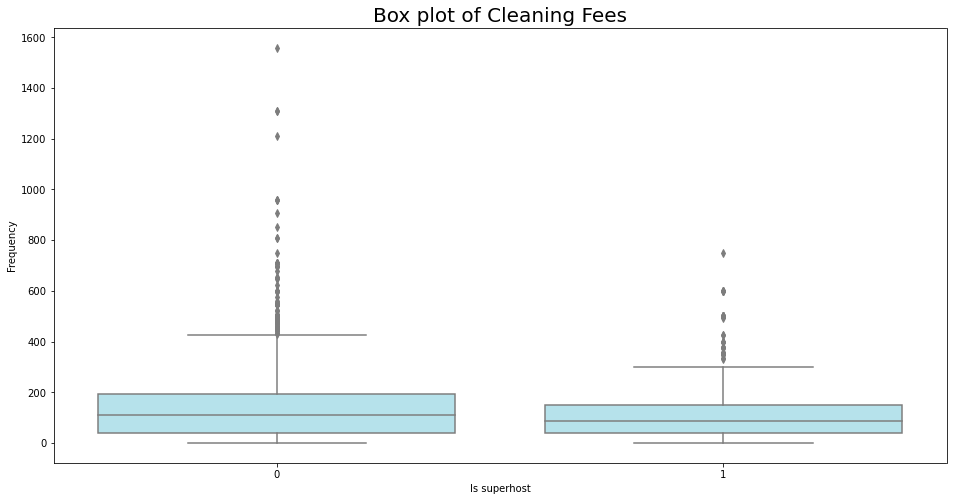

In [ ]:
plt.figure(figsize = (16,8))
g=sns.boxplot(y=data_listing['cleaning_fee'],x=data_listing['is_superhost'], color=bo[4])
g.set_xlabel("Is superhost")
g.set_ylabel("Frequency")
plt.title('Box plot of Cleaning Fees',size = 20)

Cleaning fees in case of superhosts are less than those properties owned by non superhosts.

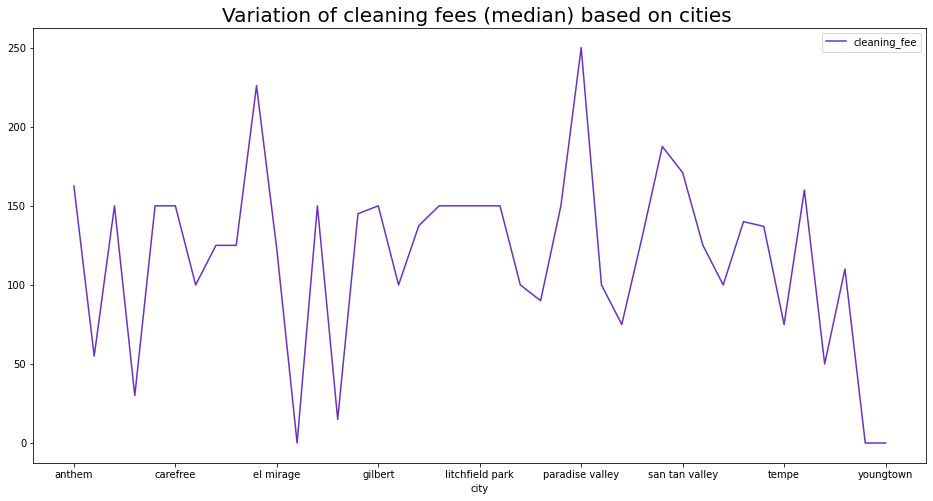

In [ ]:
grouped_properties = data_listing.groupby('city')['city','cleaning_fee'].median()
grouped_properties.plot(figsize=(16,8),color=bo[0])
plt.title('Variation of cleaning fees (median) based on cities ', size = 20)
plt.show()

We can see that the properties in the paradise valley and el mirage are having highest cleaning fees.

In [ ]:
df_merge_clean = data_df.merge(data_listing, how='inner', on='scraping_id')
df_clean_listings = df_merge_clean.copy(deep=True)
df_clean_listings['price']=df_clean_listings['price']+df_clean_listings['cleaning_fee']
df_clean_listings.to_csv('scraped_listings_clean.csv')
del df_merge_clean

## Exploring Merged data

In [ ]:
combined_data=pd.read_csv("C:\\Users\\Sajid hussain\\Desktop\\Books_UOR\\Stats machine learning\\StatsProject\\wanderjaunt\\data\\scraped_listings_clean\\scraped_listings_clean.csv")
combined_data.head()

,Unnamed: 0,scraping_id,scraped_date,date,price,available,listing,city,lon,lat,mapped_location,name,capacity,bathrooms,bedrooms,has_pool,cleaning_fee,is_superhost,host_name
0,0,2,2018-03-15,2018-04-01,250,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj
1,1,2,2018-03-15,2018-04-02,115,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj
2,2,2,2018-03-15,2018-04-03,115,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj
3,3,2,2018-03-15,2018-04-04,115,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj
4,4,2,2018-03-15,2018-04-05,150,0,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj


In [ ]:
combined_data.drop(['Unnamed: 0','listing','mapped_location','name','host_name'],axis=1,inplace=True)

In [ ]:
combined_data.head()

,scraping_id,scraped_date,date,price,available,city,lon,lat,capacity,bathrooms,bedrooms,has_pool,cleaning_fee,is_superhost
0,2,2018-03-15,2018-04-01,250,1,scottsdale,-111.916935,33.496566,7,2.5,2.0,1,150.0,1
1,2,2018-03-15,2018-04-02,115,1,scottsdale,-111.916935,33.496566,7,2.5,2.0,1,150.0,1
2,2,2018-03-15,2018-04-03,115,1,scottsdale,-111.916935,33.496566,7,2.5,2.0,1,150.0,1
3,2,2018-03-15,2018-04-04,115,1,scottsdale,-111.916935,33.496566,7,2.5,2.0,1,150.0,1
4,2,2018-03-15,2018-04-05,150,0,scottsdale,-111.916935,33.496566,7,2.5,2.0,1,150.0,1


In [ ]:
combined_data['month'] = pd.DatetimeIndex(combined_data['date']).month

In [ ]:
combined_data['profit']=combined_data['price']-combined_data['cleaning_fee']
combined_data['abnb_earning']=(0.14*combined_data['price'])+ (1.14*0.03*combined_data['is_superhost']*combined_data['price'])

In [ ]:
combined_data.describe().T

,count,mean,std,min,25%,50%,75%,max
scraping_id,16300175.0,8.859516e+06,1.058208e+07,2.000000,3835.000000,12939.000000,2.147308e+07,2.470754e+07
price,16300175.0,3.068724e+02,8.637483e+02,10.000000,100.000000,159.000000,3.000000e+02,2.500000e+04
available,16300175.0,4.880770e-01,4.998578e-01,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00
lon,16300175.0,-1.119608e+02,7.840680e-02,-112.443425,-112.014732,-111.934755,-1.119090e+02,-1.114588e+02
lat,16300175.0,3.353482e+01,9.720365e-02,33.084793,33.477169,33.508281,3.360868e+01,3.392324e+01
capacity,16300175.0,6.517274e+00,3.199865e+00,1.000000,4.000000,6.000000,8.000000e+00,2.600000e+01
bathrooms,16300175.0,2.055569e+00,9.248494e-01,0.000000,1.500000,2.000000,2.000000e+00,1.000000e+01
bedrooms,16300175.0,2.582115e+00,1.301425e+00,0.000000,2.000000,2.000000,3.000000e+00,1.200000e+01
has_pool,16300175.0,7.704147e-01,4.205661e-01,0.000000,1.000000,1.000000,1.000000e+00,1.000000e+00
cleaning_fee,16300175.0,1.280733e+02,1.153594e+02,0.000000,50.000000,105.000000,1.750000e+02,1.559000e+03


Text(0.5, 1.0, 'Distribution of Profit')

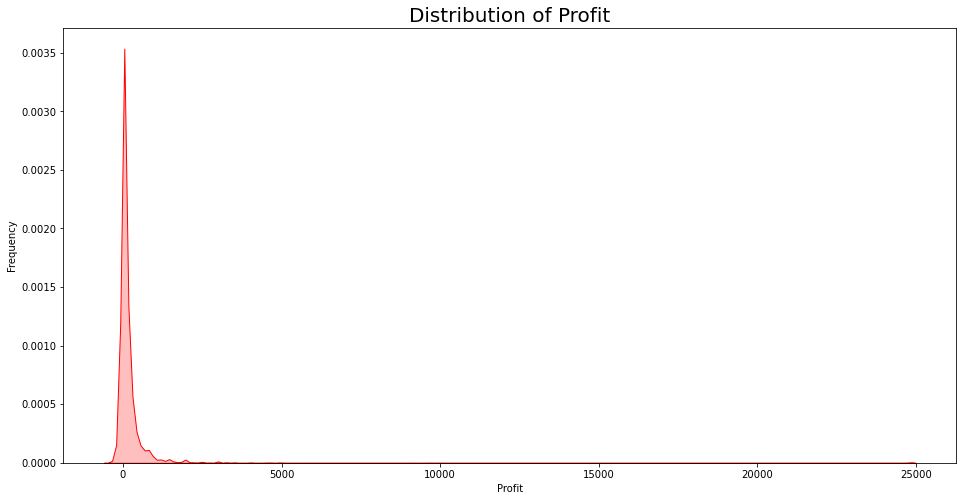

In [ ]:
plt.figure(figsize = (16,8))
g=sns.kdeplot(combined_data['profit'], color="Red", shade = True)
g.set_xlabel("Profit")
g.set_ylabel("Frequency")
plt.title('Distribution of Profit',size = 20)

following the price and cleaning fees, profit is right skewed.

Text(0.5, 1.0, 'Distribution of Air bnb earning')

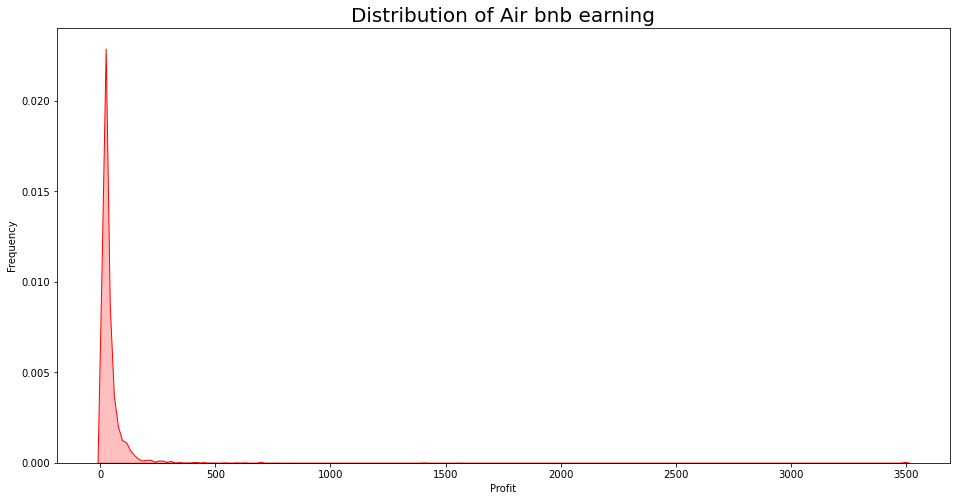

In [ ]:
plt.figure(figsize = (16,8))
g=sns.kdeplot(combined_data['abnb_earning'], color="Red", shade = True)
g.set_xlabel("Profit")
g.set_ylabel("Frequency")
plt.title('Distribution of Air bnb earning',size = 20)

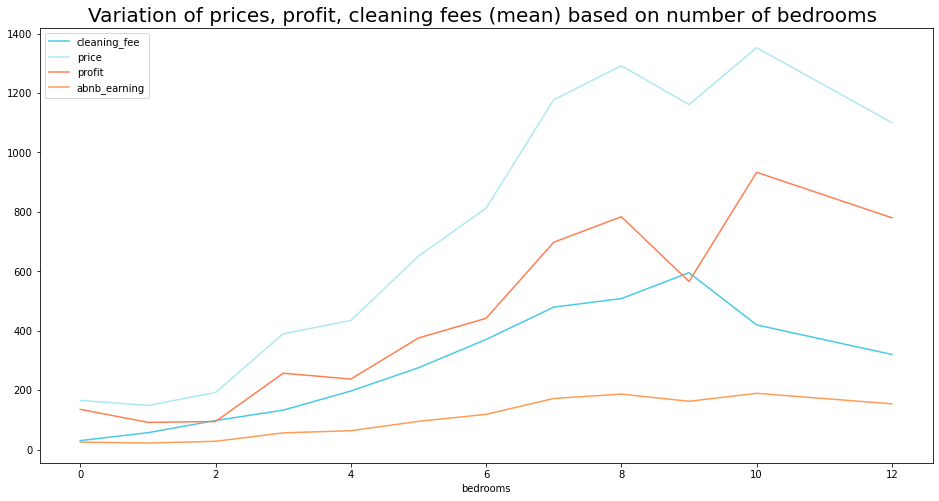

In [ ]:
grouped_properties = combined_data.groupby('bedrooms')['cleaning_fee','price','profit','abnb_earning'].mean()
grouped_properties.plot(figsize=(16,8),color=bo[3:7])
plt.title('Variation of prices, profit, cleaning fees (mean) based on number of bedrooms ', size = 20)
plt.show()

We can see there is a gradual profit rise, with increase in the number of bedrooms. Surprisingly, on properties with 9 bedrooms we get the highest profit on average amongst all the properties when plotting the based mean. But we cannot trust since we have observed the outliers in prices columns, lets try the same with median.

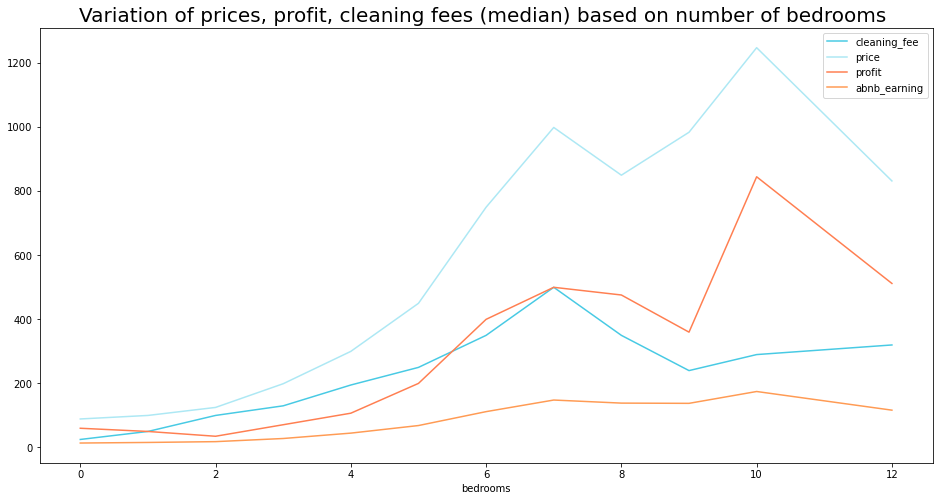

In [ ]:
grouped_properties = combined_data.groupby('bedrooms')['cleaning_fee','price','profit','abnb_earning'].median()
grouped_properties.plot(figsize=(16,8),color=bo[3:7])
plt.title('Variation of prices, profit, cleaning fees (median) based on number of bedrooms ', size = 20)
plt.show()

To our guess, we can see now the trend has changed, now the properites with 10 bedrooms have the highest profit on average.

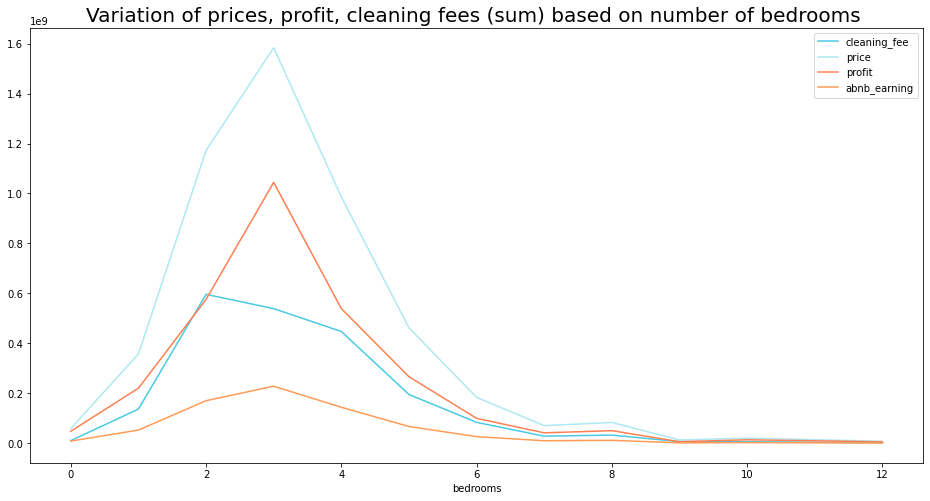

In [ ]:
grouped_properties = combined_data.groupby('bedrooms')['cleaning_fee','price','profit','abnb_earning'].sum()
grouped_properties.plot(figsize=(16,8),color=bo[3:7])
plt.title('Variation of prices, profit, cleaning fees (sum) based on number of bedrooms ', size = 20)
plt.show()

However, if we look at the sum of the overall profits for the months of may and april, the 3 bedroom properties have the maximum profit.

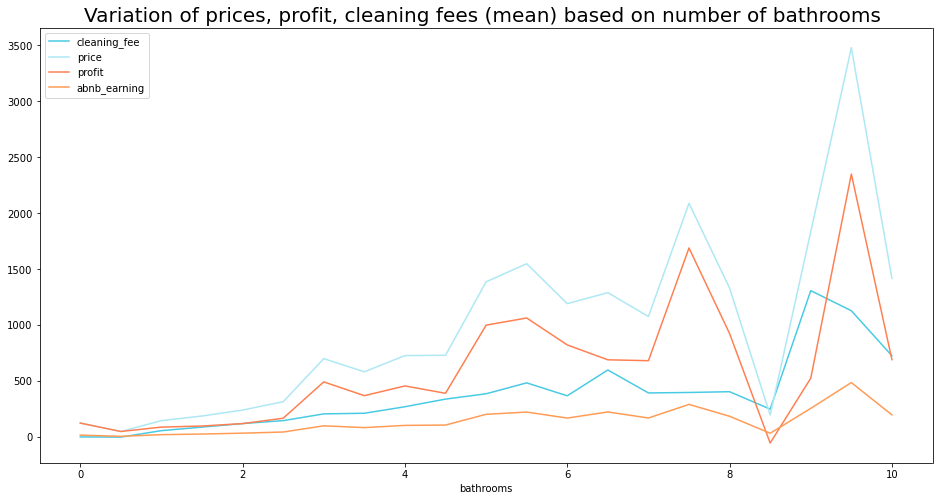

In [ ]:
grouped_properties = combined_data.groupby('bathrooms')['cleaning_fee','price','profit','abnb_earning'].mean()
grouped_properties.plot(figsize=(16,8),color=bo[3:7])
plt.title('Variation of prices, profit, cleaning fees (mean) based on number of bathrooms ', size = 20)
plt.show()

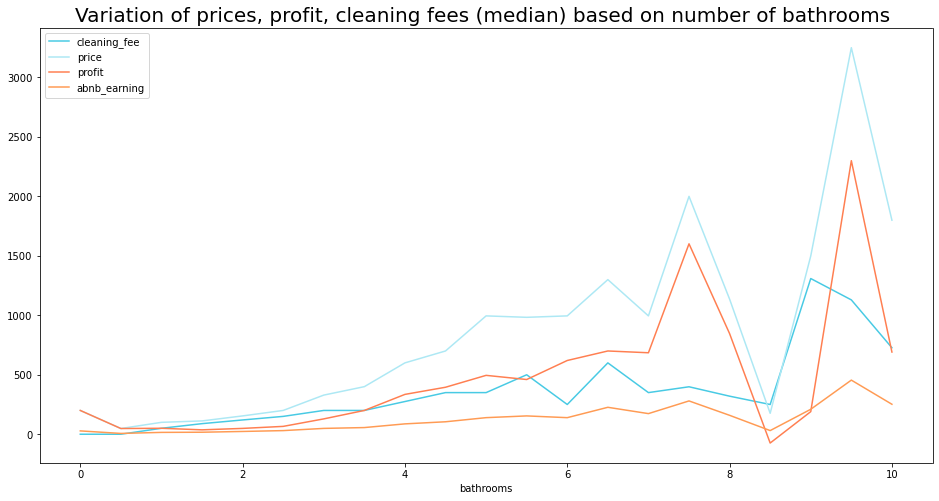

In [ ]:
grouped_properties = combined_data.groupby('bathrooms')['cleaning_fee','price','profit','abnb_earning'].median()
grouped_properties.plot(figsize=(16,8),color=bo[3:7])
plt.title('Variation of prices, profit, cleaning fees (median) based on number of bathrooms ', size = 20)
plt.show()

When comparing the prices based on the bathrooms, we again tend find that properties having more than 9 bathrooms have high profits on average.

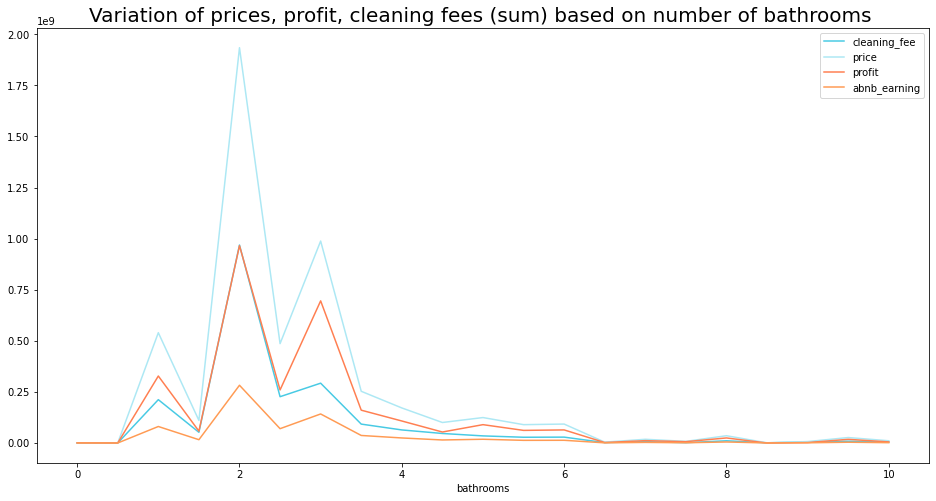

In [ ]:
grouped_properties = combined_data.groupby('bathrooms')['cleaning_fee','price','profit','abnb_earning'].sum()
grouped_properties.plot(figsize=(16,8),color=bo[3:7])
plt.title('Variation of prices, profit, cleaning fees (sum) based on number of bathrooms ', size = 20)
plt.show()

However, if we look at the sum of the overall profits for the months of may and april, the 3 bedroom and 2 bathroom properties have the maximum profit. this confirms the fact that renters are adviced to have 2-3 bedrooms and bathrooms so that they can get higher profits in certain period of time rather than having higher number bedrooms and bathrooms as they give high profits on average.

###  In which month do properties appear to generate more revenue? April or May?

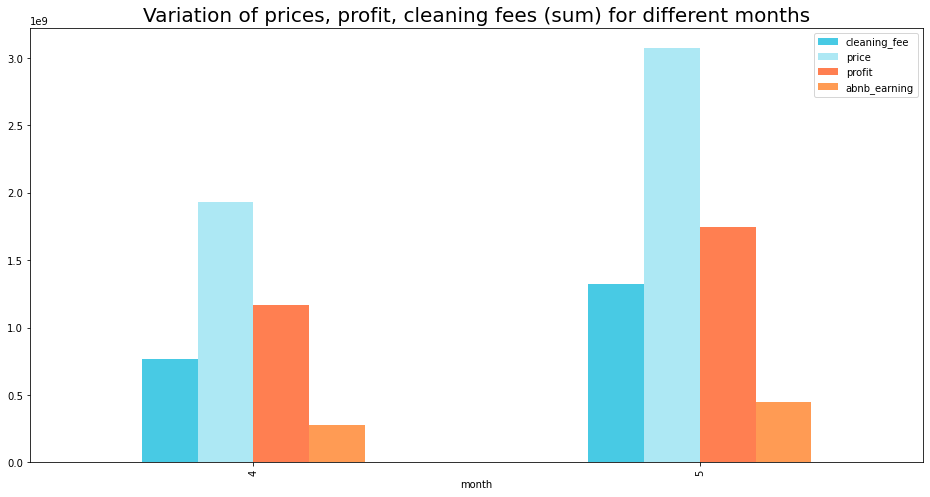

In [ ]:
grouped_properties = combined_data.groupby('month')['cleaning_fee','price','profit','abnb_earning'].sum()
grouped_properties.plot(figsize=(16,8),color=bo[3:7],kind='bar')
plt.title('Variation of prices, profit, cleaning fees (sum) for different months', size = 20)
plt.show()

In [ ]:
grouped_properties.sort_values(by=['profit'],ascending=False)

,cleaning_fee,price,profit,abnb_earning
month,,,,
5,1.322978e+09,3072687123,1.749709e+09,4.472943e+08
4,7.646395e+08,1929386804,1.164747e+09,2.809703e+08


Month of May has profit than month of April. This is due to the fact that the prices have gone up from april which we observed from the line plot before.

### Which month do properities can potentially generate more revenue if only booked listings are considered?

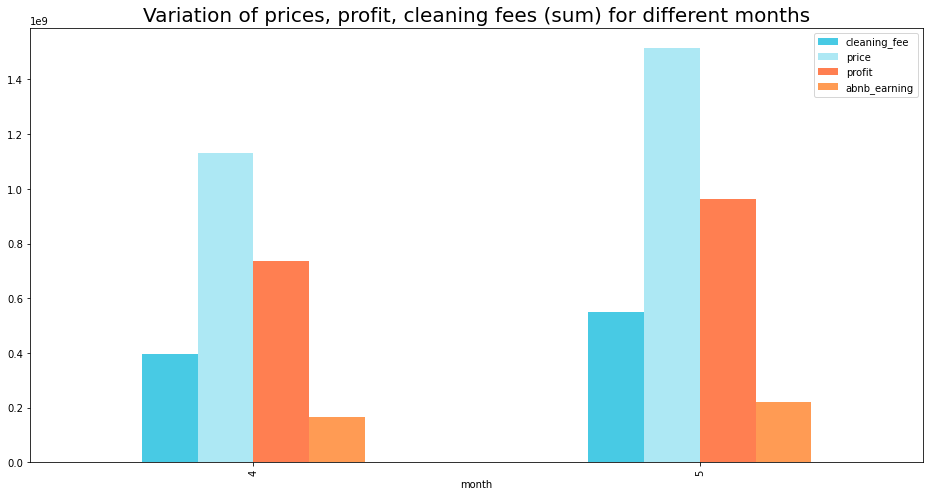

In [ ]:
grouped_properties = combined_data[combined_data["available"]==0].groupby('month')['cleaning_fee','price','profit','abnb_earning'].sum()
grouped_properties.plot(figsize=(16,8),color=bo[3:7], kind='bar')
plt.title('Variation of prices, profit, cleaning fees (sum) for different months', size = 20)
plt.show()

In [ ]:
grouped_properties.sort_values(by=['profit'],ascending=False)

,cleaning_fee,price,profit,abnb_earning
month,,,,
5,550017947.0,1514134265,964116318.0,2.205096e+08
4,395133652.0,1131006079,735872427.0,1.649373e+08


When considering only the hotels which was available, the profit is high for the month of May

### How much more revenue do places with 3 bedrooms make vs. places with 2 bedrooms?

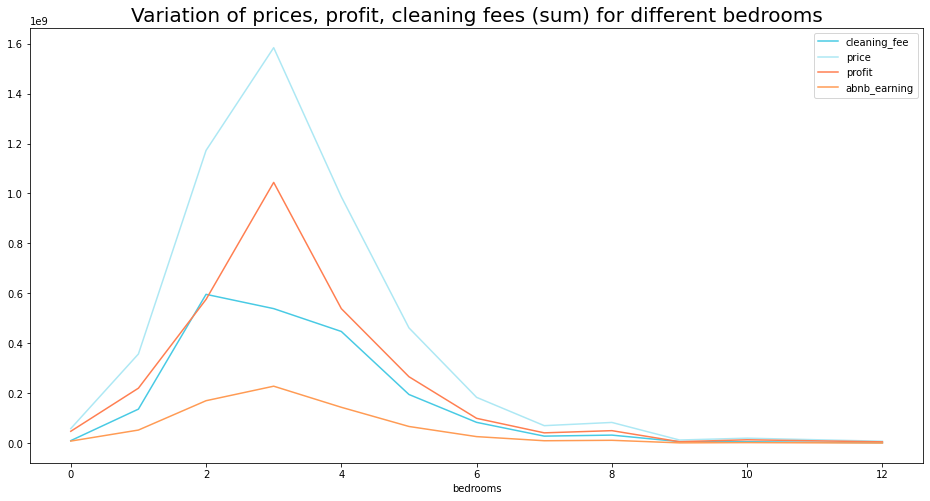

In [ ]:
grouped_properties = combined_data.groupby('bedrooms')['cleaning_fee','price','profit','abnb_earning'].sum()
grouped_properties.plot(figsize=(16,8),color=bo[3:7])
plt.title('Variation of prices, profit, cleaning fees (sum) for different bedrooms', size = 20)
plt.show()

In [ ]:
grouped_properties.sort_values(by=['profit'],ascending=False)

,cleaning_fee,price,profit,abnb_earning
bedrooms,,,,
3.0,539162623.0,1583590441,1.044428e+09,2.286815e+08
2.0,596332194.0,1172410245,5.760781e+08,1.705890e+08
4.0,447699868.0,986792599,5.390927e+08,1.442604e+08
5.0,195485335.0,462062839,2.665775e+08,6.745638e+07
1.0,136900972.0,357635222,2.207342e+08,5.313002e+07
6.0,83937421.0,184001642,1.000642e+08,2.685675e+07
8.0,32889020.0,83602391,5.071337e+07,1.208189e+07
0.0,10771857.0,58982565,4.821071e+07,8.957309e+06
7.0,28803086.0,70727181,4.192410e+07,1.033378e+07


Three bedrooms properties generate more revenue than those properties with 2 bedrooms.

### What are the most valuable cities for 3-bedroom or 2-bedroom apartments?

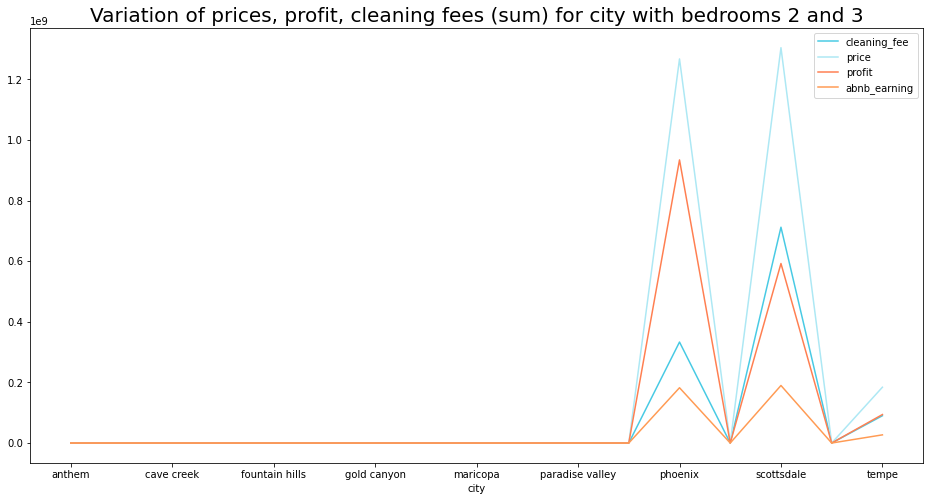

In [ ]:
grouped_properties = combined_data[combined_data['bedrooms'].isin([2,3])].groupby(['city'])['cleaning_fee','price','profit','abnb_earning'].sum()
grouped_properties.plot(figsize=(16,8),color=bo[3:7])
plt.title('Variation of prices, profit, cleaning fees (sum) for city with bedrooms 2 and 3', size = 20)
plt.show()

In [ ]:
grouped_properties.sort_values(by=['profit'],ascending=False)

,cleaning_fee,price,profit,abnb_earning
city,,,,
phoenix,333144591.0,1267246908,934102317.0,1.824070e+08
scottsdale,712022916.0,1304311515,592288599.0,1.898690e+08
tempe,90133025.0,184144766,94011741.0,2.695183e+07
paradise valley,0.0,85400,85400.0,1.195600e+04
goodyear,0.0,13840,13840.0,1.937600e+03
gold canyon,12200.0,18300,6100.0,2.562000e+03
anthem,9150.0,15250,6100.0,2.135000e+03
fountain hills,17080.0,19215,2135.0,2.690100e+03
cave creek,4575.0,6100,1525.0,8.540000e+02


### How much of a difference does being a superhost, on average, have on the price of a listing?

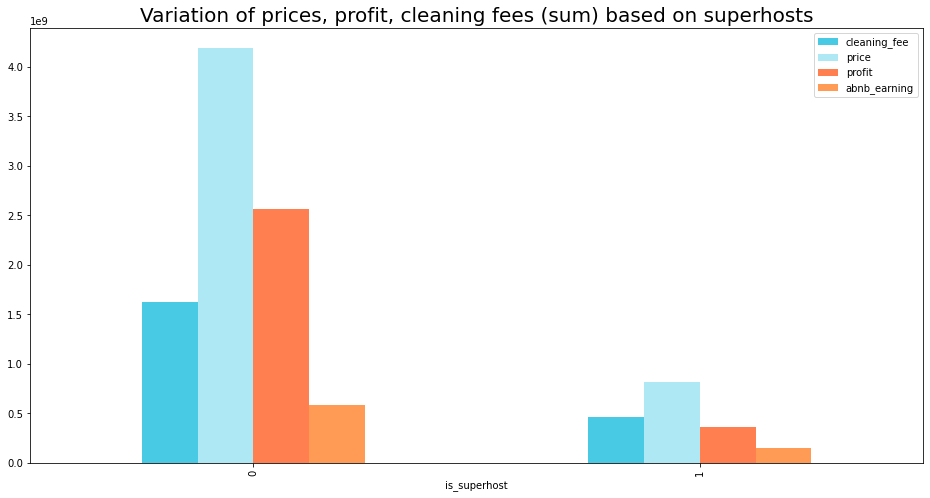

In [ ]:
grouped_properties = combined_data.groupby(['is_superhost'])['cleaning_fee','price','profit','abnb_earning'].sum()
grouped_properties.plot(figsize=(16,8),color=bo[3:7],kind='bar')
plt.title('Variation of prices, profit, cleaning fees (sum) based on superhosts', size = 20)
plt.show()

In [ ]:
grouped_properties.sort_values(by=['profit'],ascending=False)

,cleaning_fee,price,profit,abnb_earning
is_superhost,,,,
0,1.624379e+09,4184111495,2.559732e+09,5.857756e+08
1,4.632383e+08,817962432,3.547242e+08,1.424891e+08


### Which features are most likely to be interdependent on others? What is their variance inflation?

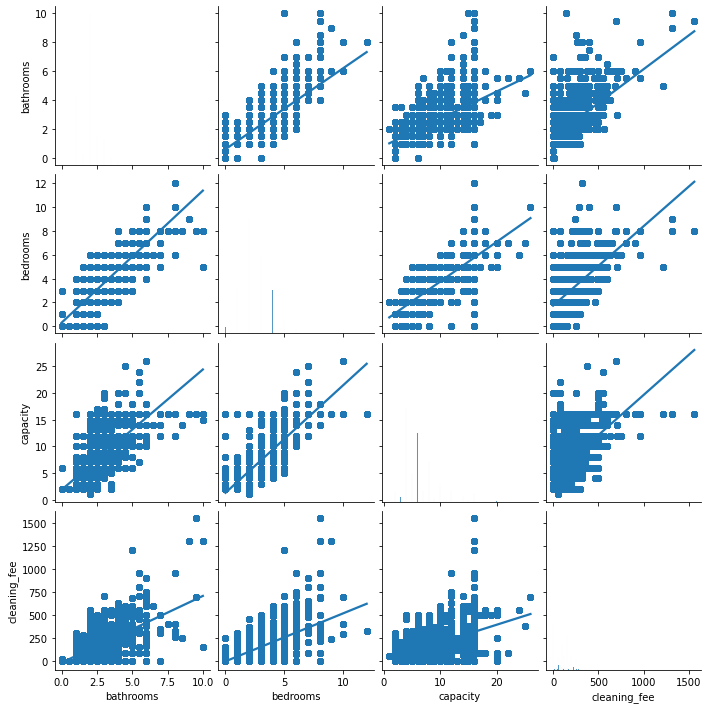

In [ ]:
%matplotlib inline
COMBINED=df_clean_listings[['bathrooms','bedrooms','capacity', 'cleaning_fee']]
COMBINED=COMBINED[~COMBINED.index.duplicated()] 
sns.pairplot(COMBINED,kind="reg")

## Handling of Longitude and Latitiude 

In [ ]:
trial=combined_data[['lat','lon']]
trial.head()

,lat,lon
0,33.496566,-111.916935
1,33.496566,-111.916935
2,33.496566,-111.916935
3,33.496566,-111.916935
4,33.496566,-111.916935


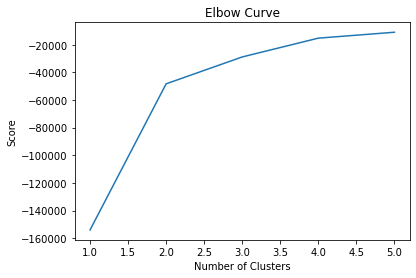

In [ ]:
K_clusters = range(1,6)
kmeans = [KMeans(n_clusters=i)for i in K_clusters]
Y_axis = trial[['lat']]
X_axis = trial[['lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
kmeans3 = KMeans(n_clusters = 4, init ='k-means++')
kmeans3.fit(trial) 
# Compute k-means clustering.
trial['cluster_label'] = kmeans3.fit_predict(trial)
centers = kmeans3.cluster_centers_ 
# Coordinates of cluster centers.
labels = kmeans3.predict(trial) 
# Labels of each point
trial.head(10)

,lat,lon,cluster_label
0,33.496566,-111.916935,1
1,33.496566,-111.916935,1
2,33.496566,-111.916935,1
3,33.496566,-111.916935,1
4,33.496566,-111.916935,1
5,33.496566,-111.916935,1
6,33.496566,-111.916935,1
7,33.496566,-111.916935,1
8,33.496566,-111.916935,1
9,33.496566,-111.916935,1


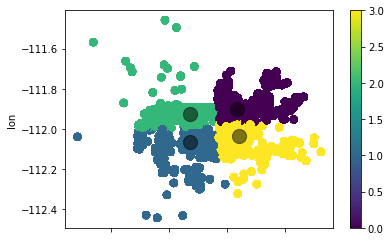

In [ ]:
trial.plot.scatter(x = 'lat', y = 'lon', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
combined_data['loc']=trial['cluster_label']
combined_data.head()

,scraping_id,scraped_date,date,price,available,listing,city,lon,lat,mapped_location,name,capacity,bathrooms,bedrooms,has_pool,cleaning_fee,is_superhost,host_name,airbnb_earning,loc
0,2,2018-03-15,2018-04-01,400.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,69.680,1
1,2,2018-03-15,2018-04-02,265.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,46.163,1
2,2,2018-03-15,2018-04-03,265.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,46.163,1
3,2,2018-03-15,2018-04-04,265.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,46.163,1
4,2,2018-03-15,2018-04-05,300.0,0,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,52.260,1


In [ ]:
df_clean_listings.to_csv('final_clean.csv')

## Forcasting the price 

In [ ]:
df_clean_listings=pd.read_csv('final_clean.csv')

In [ ]:
df=df_clean_listings[['price','date']].copy(deep=True)

In [ ]:
df = df.rename({'price': 'y', 'date': 'ds'}, axis=1)
df.head()

,y,ds
0,400.0,2018-04-01
1,265.0,2018-04-02
2,265.0,2018-04-03
3,265.0,2018-04-04
4,300.0,2018-04-05


In [ ]:
m=Prophet()
m.fit(df)
future=m.make_future_dataframe(periods=365)
future.tail()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
421,2019-05-27
422,2019-05-28
423,2019-05-29
424,2019-05-30
425,2019-05-31


In [ ]:
forecast=m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
421,2019-05-27,409.946657,-3517.382905,4272.774892
422,2019-05-28,408.837167,-3481.736243,4490.467141
423,2019-05-29,412.199642,-3321.625799,4420.490918
424,2019-05-30,424.091864,-3426.716887,4267.243982
425,2019-05-31,441.984633,-3554.204296,4439.236532


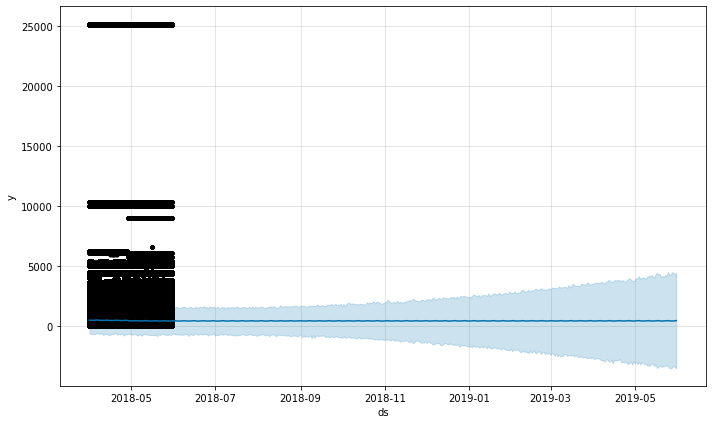

In [ ]:
fig1=m.plot(forecast)

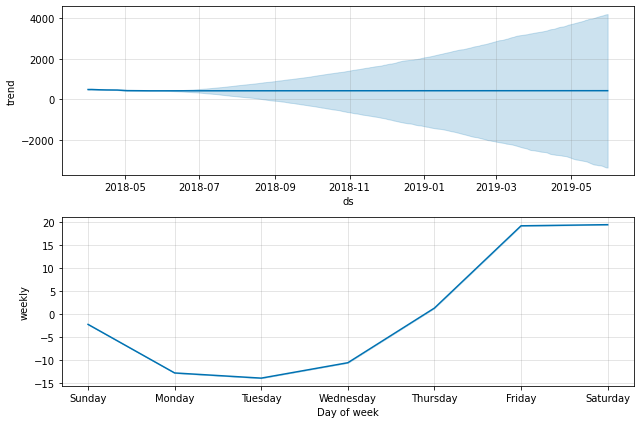

In [ ]:
fig2=m.plot_components(forecast)

In [ ]:
plot_components_plotly(m,forecast)

## VIfactors for features

In [ ]:
X = df_clean_listings[['bathrooms', 'bedrooms','capacity', 'cleaning_fee']]
vif = pd.DataFrame()
vif['vif_factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns

In [ ]:
vif

,vif_factor,features
0,13.453956,bathrooms
1,23.127717,bedrooms
2,14.651957,capacity
3,3.598070,cleaning_fee


# Statistical Test

In [ ]:
df_clean_listings = pd.read_csv('scraped_listings_clean.csv')
df_clean_listings['price']=df_clean_listings['price']+df_clean_listings['cleaning_fee']
df_clean_listings['airbnb_earning']=(0.14*df_clean_listings['price'])+ (1.14*0.03*df_clean_listings['is_superhost']*df_clean_listings['price'])
df_clean_listings.head()

,Unnamed: 0,scraping_id,scraped_date,date,price,available,listing,city,lon,lat,mapped_location,name,capacity,bathrooms,bedrooms,has_pool,cleaning_fee,is_superhost,host_name,airbnb_earning
0,0,2,2018-03-15,2018-04-01,400.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,69.680
1,1,2,2018-03-15,2018-04-02,265.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,46.163
2,2,2,2018-03-15,2018-04-03,265.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,46.163
3,3,2,2018-03-15,2018-04-04,265.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,46.163
4,4,2,2018-03-15,2018-04-05,300.0,0,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,52.260


In [ ]:
df_clean_listings = df_clean_listings.drop(df_clean_listings.columns[[0, 1]], axis=1)
df_clean_listings.head(5)

,scraped_date,date,price,available,listing,city,lon,lat,mapped_location,name,capacity,bathrooms,bedrooms,has_pool,cleaning_fee,is_superhost,host_name,airbnb_earning
0,2018-03-15,2018-04-01,400.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,69.680
1,2018-03-15,2018-04-02,265.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,46.163
2,2018-03-15,2018-04-03,265.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,46.163
3,2018-03-15,2018-04-04,265.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,46.163
4,2018-03-15,2018-04-05,300.0,0,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,52.260


In [ ]:
df_clean_chisq = df_clean_listings[['price', 'available','city','capacity',	'bathrooms',	'bedrooms',	'has_pool', 'is_superhost']]
df_clean_chisq

,price,available,city,capacity,bathrooms,bedrooms,has_pool,is_superhost
0,400.0,1,scottsdale,7,2.5,2.0,1,1
1,265.0,1,scottsdale,7,2.5,2.0,1,1
2,265.0,1,scottsdale,7,2.5,2.0,1,1
3,265.0,1,scottsdale,7,2.5,2.0,1,1
4,300.0,0,scottsdale,7,2.5,2.0,1,1
...,...,...,...,...,...,...,...,...
16300170,400.0,0,phoenix,5,2.5,3.0,1,0
16300171,400.0,0,phoenix,5,2.5,3.0,1,0
16300172,400.0,0,phoenix,5,2.5,3.0,1,0
16300173,400.0,0,phoenix,5,2.5,3.0,1,0


## Converting the 'price' column into a categorical column

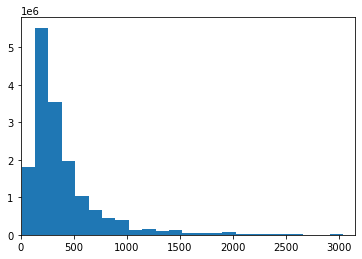

In [ ]:
plt.hist(df_clean_chisq['price'], bins = 200);
plt.xlim(0, df_clean_chisq['price'].max()/8.0)
plt.show()

In [ ]:
price_cat = pd.cut(df_clean_chisq.price,bins=[0, of lis100, 1000, 2000, 3000],labels=["Cheap", "Mid-Range", "Expensive", "Very Expensive"])
price_cat

0           Mid-Range
1           Mid-Range
2           Mid-Range
3           Mid-Range
4           Mid-Range
              ...    
16300170    Mid-Range
16300171    Mid-Range
16300172    Mid-Range
16300173    Mid-Range
16300174    Mid-Range
Name: price, Length: 16300175, dtype: category
Categories (4, object): ['Cheap' < 'Mid-Range' < 'Expensive' < 'Very Expensive']

In [ ]:
df_clean_chisq.insert(0, "price_cat", price_cat)
df_clean_chisq = df_clean_chisq.drop(df_clean_chisq.columns[[1]], axis=1)
df_clean_chisq

,price_cat,available,city,capacity,bathrooms,bedrooms,has_pool,is_superhost
0,Mid-Range,1,scottsdale,7,2.5,2.0,1,1
1,Mid-Range,1,scottsdale,7,2.5,2.0,1,1
2,Mid-Range,1,scottsdale,7,2.5,2.0,1,1
3,Mid-Range,1,scottsdale,7,2.5,2.0,1,1
4,Mid-Range,0,scottsdale,7,2.5,2.0,1,1
...,...,...,...,...,...,...,...,...
16300170,Mid-Range,0,phoenix,5,2.5,3.0,1,0
16300171,Mid-Range,0,phoenix,5,2.5,3.0,1,0
16300172,Mid-Range,0,phoenix,5,2.5,3.0,1,0
16300173,Mid-Range,0,phoenix,5,2.5,3.0,1,0


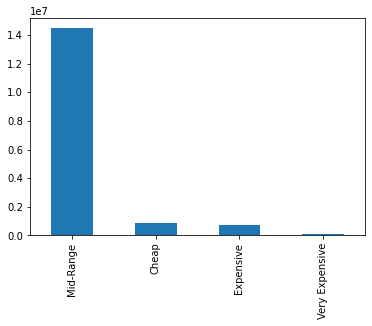

In [ ]:
df_clean_chisq['price_cat'].value_counts().plot(kind='bar')
plt.show()

## Converting the 'capacity' column into a categorical column

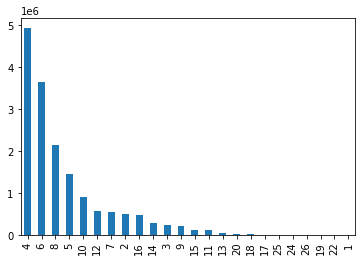

In [ ]:
df_clean_chisq['capacity'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
capacity_cat = pd.cut(df_clean_chisq.capacity, bins=[0, 2, 6, 26],labels=["1-2 guests", "3-6 guests", "More than 6 guests"])
capacity_cat

0           More than 6 guests
1           More than 6 guests
2           More than 6 guests
3           More than 6 guests
4           More than 6 guests
                   ...        
16300170            3-6 guests
16300171            3-6 guests
16300172            3-6 guests
16300173            3-6 guests
16300174            3-6 guests
Name: capacity, Length: 16300175, dtype: category
Categories (3, object): ['1-2 guests' < '3-6 guests' < 'More than 6 guests']

In [ ]:
df_clean_chisq.insert(1, "capacity_cat", capacity_cat)
df_clean_chisq = df_clean_chisq.drop(df_clean_chisq.columns[[4]], axis=1)
df_clean_chisq

,price_cat,capacity_cat,available,city,bathrooms,bedrooms,has_pool,is_superhost
0,Mid-Range,More than 6 guests,1,scottsdale,2.5,2.0,1,1
1,Mid-Range,More than 6 guests,1,scottsdale,2.5,2.0,1,1
2,Mid-Range,More than 6 guests,1,scottsdale,2.5,2.0,1,1
3,Mid-Range,More than 6 guests,1,scottsdale,2.5,2.0,1,1
4,Mid-Range,More than 6 guests,0,scottsdale,2.5,2.0,1,1
...,...,...,...,...,...,...,...,...
16300170,Mid-Range,3-6 guests,0,phoenix,2.5,3.0,1,0
16300171,Mid-Range,3-6 guests,0,phoenix,2.5,3.0,1,0
16300172,Mid-Range,3-6 guests,0,phoenix,2.5,3.0,1,0
16300173,Mid-Range,3-6 guests,0,phoenix,2.5,3.0,1,0


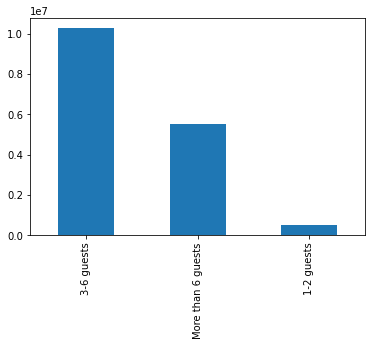

In [ ]:
df_clean_chisq['capacity_cat'].value_counts().plot(kind='bar')
plt.show()

## Converting the 'bathrooms' column into a categorical column

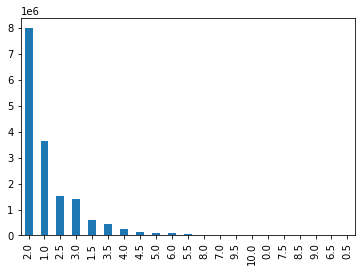

In [ ]:
df_clean_chisq['bathrooms'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
bathrooms_cat = pd.cut(df_clean_chisq.bathrooms, bins=[0, 1, 2, 3, 10],labels=["1 bathroom", "2 bathrooms", "3 bathrooms", "More than 3 bathrooms"])
bathrooms_cat

0           3 bathrooms
1           3 bathrooms
2           3 bathrooms
3           3 bathrooms
4           3 bathrooms
               ...     
16300170    3 bathrooms
16300171    3 bathrooms
16300172    3 bathrooms
16300173    3 bathrooms
16300174    3 bathrooms
Name: bathrooms, Length: 16300175, dtype: category
Categories (4, object): ['1 bathroom' < '2 bathrooms' < '3 bathrooms' < 'More than 3 bathrooms']

In [ ]:
df_clean_chisq.insert(2, "bathrooms_cat", bathrooms_cat)
df_clean_chisq = df_clean_chisq.drop(df_clean_chisq.columns[[5]], axis=1)
df_clean_chisq

,price_cat,capacity_cat,bathrooms_cat,available,city,bedrooms,has_pool,is_superhost
0,Mid-Range,More than 6 guests,3 bathrooms,1,scottsdale,2.0,1,1
1,Mid-Range,More than 6 guests,3 bathrooms,1,scottsdale,2.0,1,1
2,Mid-Range,More than 6 guests,3 bathrooms,1,scottsdale,2.0,1,1
3,Mid-Range,More than 6 guests,3 bathrooms,1,scottsdale,2.0,1,1
4,Mid-Range,More than 6 guests,3 bathrooms,0,scottsdale,2.0,1,1
...,...,...,...,...,...,...,...,...
16300170,Mid-Range,3-6 guests,3 bathrooms,0,phoenix,3.0,1,0
16300171,Mid-Range,3-6 guests,3 bathrooms,0,phoenix,3.0,1,0
16300172,Mid-Range,3-6 guests,3 bathrooms,0,phoenix,3.0,1,0
16300173,Mid-Range,3-6 guests,3 bathrooms,0,phoenix,3.0,1,0


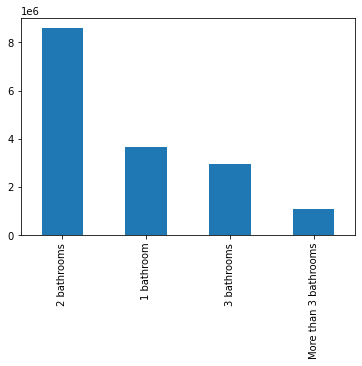

In [ ]:
df_clean_chisq['bathrooms_cat'].value_counts().plot(kind='bar')
plt.show()

## Converting the 'bedrooms' column into a categorical column

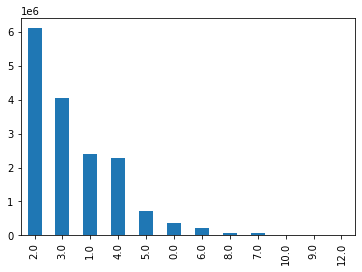

In [ ]:
df_clean_chisq['bedrooms'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
bedrooms_cat = pd.cut(df_clean_chisq.bedrooms, bins=[0, 1, 2, 3, 4, 8, 12],labels=["1 bedroom", "2 bedrooms", "3 bedrooms", "4 bedrooms", "5-8 bedrooms", "More than 8 bedrooms"])
bedrooms_cat

0           2 bedrooms
1           2 bedrooms
2           2 bedrooms
3           2 bedrooms
4           2 bedrooms
               ...    
16300170    3 bedrooms
16300171    3 bedrooms
16300172    3 bedrooms
16300173    3 bedrooms
16300174    3 bedrooms
Name: bedrooms, Length: 16300175, dtype: category
Categories (6, object): ['1 bedroom' < '2 bedrooms' < '3 bedrooms' < '4 bedrooms' < '5-8 bedrooms' < 'More than 8 bedrooms']

In [ ]:
df_clean_chisq.insert(3, "bedrooms_cat", bedrooms_cat)
df_clean_chisq = df_clean_chisq.drop(df_clean_chisq.columns[[6]], axis=1)
df_clean_chisq

,price_cat,capacity_cat,bathrooms_cat,bedrooms_cat,available,city,has_pool,is_superhost
0,Mid-Range,More than 6 guests,3 bathrooms,2 bedrooms,1,scottsdale,1,1
1,Mid-Range,More than 6 guests,3 bathrooms,2 bedrooms,1,scottsdale,1,1
2,Mid-Range,More than 6 guests,3 bathrooms,2 bedrooms,1,scottsdale,1,1
3,Mid-Range,More than 6 guests,3 bathrooms,2 bedrooms,1,scottsdale,1,1
4,Mid-Range,More than 6 guests,3 bathrooms,2 bedrooms,0,scottsdale,1,1
...,...,...,...,...,...,...,...,...
16300170,Mid-Range,3-6 guests,3 bathrooms,3 bedrooms,0,phoenix,1,0
16300171,Mid-Range,3-6 guests,3 bathrooms,3 bedrooms,0,phoenix,1,0
16300172,Mid-Range,3-6 guests,3 bathrooms,3 bedrooms,0,phoenix,1,0
16300173,Mid-Range,3-6 guests,3 bathrooms,3 bedrooms,0,phoenix,1,0


In [ ]:
df_clean_chisq.to_csv("df_clean_cat.csv", index_label=False)


In [ ]:
df_clean_chisq

,price_cat,capacity_cat,bathrooms_cat,bedrooms_cat,available,city,has_pool,is_superhost
0,Mid-Range,More than 6 guests,3 bathrooms,2 bedrooms,1,scottsdale,1,1
1,Mid-Range,More than 6 guests,3 bathrooms,2 bedrooms,1,scottsdale,1,1
2,Mid-Range,More than 6 guests,3 bathrooms,2 bedrooms,1,scottsdale,1,1
3,Mid-Range,More than 6 guests,3 bathrooms,2 bedrooms,1,scottsdale,1,1
4,Mid-Range,More than 6 guests,3 bathrooms,2 bedrooms,0,scottsdale,1,1
...,...,...,...,...,...,...,...,...
16300170,Mid-Range,3-6 guests,3 bathrooms,3 bedrooms,0,phoenix,1,0
16300171,Mid-Range,3-6 guests,3 bathrooms,3 bedrooms,0,phoenix,1,0
16300172,Mid-Range,3-6 guests,3 bathrooms,3 bedrooms,0,phoenix,1,0
16300173,Mid-Range,3-6 guests,3 bathrooms,3 bedrooms,0,phoenix,1,0


## Chi-Square Tests of Independence



1. The Chi-Square Test of Independence determines whether there is an association between categorical variables (i.e., whether the variables are independent or related).
2. It is a nonparametric test.
3. This test is also known as, Chi-Square Test of Association.
4. This test utilizes a contingency table to analyze the data. A contingency table (also known as a cross-tabulation, crosstab, or two-way table) is an arrangement in which data is classified according to two categorical variables. The categories for one variable appear in the rows, and the categories for the other variable appear in columns. Each variable must have two or more categories. Each cell reflects the total count of cases for a specific pair of categories.

Following table shows how to interpret Cramer's V which we will be using for our analyses:




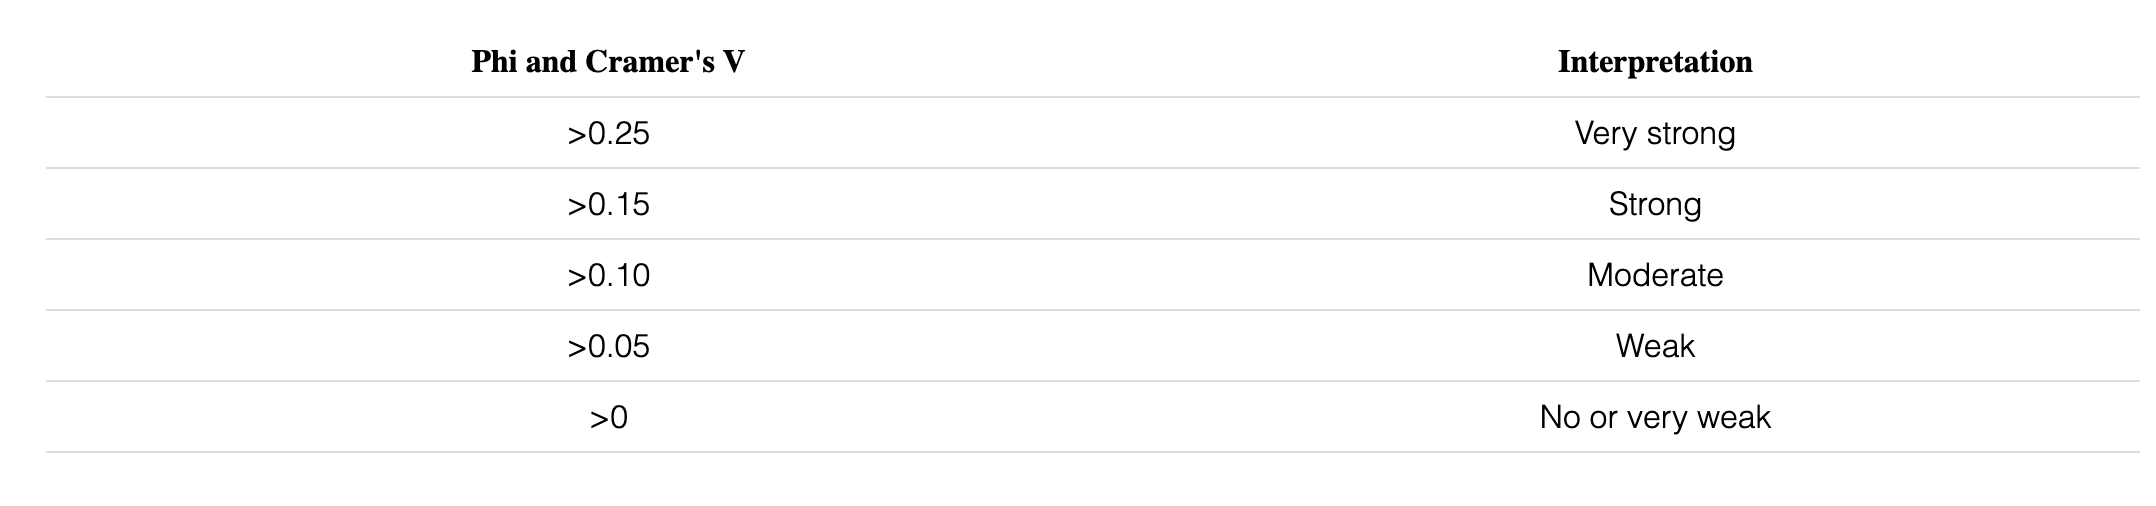






### price_cat v/s available

In [ ]:
rp.summary_cat(df_clean_chisq[["price_cat", "available"]])

,Variable,Outcome,Count,Percent
0,price_cat,Mid-Range,14465267,89.22
1,,Cheap,890486,5.49
2,,Expensive,734723,4.53
3,,Very Expensive,122484,0.76
4,available,0,8344435,51.19
5,,1,7955740,48.81


In [ ]:
crosstab = pd.crosstab(df_clean_chisq["price_cat"], df_clean_chisq["available"])
crosstab


available,0,1
price_cat,,
Cheap,627937,262549
Mid-Range,7145260,7320007
Expensive,450616,284107
Very Expensive,73240,49244


In [ ]:
crosstab, test_results, expected = rp.crosstab(df_clean_chisq["price_cat"], df_clean_chisq["available"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")




In [ ]:
crosstab

available               
available              0      1     All
price_cat                              
Cheap               3.87   1.62    5.49
Mid-Range          44.07  45.15   89.22
Expensive           2.78   1.75    4.53
Very Expensive      0.45   0.30    0.76
All                51.18  48.82  100.00

In [ ]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 3.0) =,185617.6413
1,p-value =,0.0000
2,Cramer's V =,0.1070



*The Cramer's V value is 0.1006. This indicates a moderate correlation between the price range of the Air BnBs and their availibility.*




In [ ]:
expected

available              
available                  0             1
price_cat                                 
Cheap           4.557101e+05  4.347759e+05
Mid-Range       7.402663e+06  7.062604e+06
Expensive       3.759977e+05  3.587253e+05
Very Expensive  6.268172e+04  5.980228e+04

### capacity_cat v/s available


In [ ]:
rp.summary_cat(df_clean_chisq[["capacity_cat", "available"]])

,Variable,Outcome,Count,Percent
0,capacity_cat,3-6 guests,10272923,63.02
1,,More than 6 guests,5519784,33.86
2,,1-2 guests,507468,3.11
3,available,0,8344435,51.19
4,,1,7955740,48.81


In [ ]:
crosstab = pd.crosstab(df_clean_chisq["capacity_cat"], df_clean_chisq["available"])
crosstab


available,0,1
capacity_cat,,
1-2 guests,318808,188660
3-6 guests,5379515,4893408
More than 6 guests,2646112,2873672


In [ ]:
crosstab, test_results, expected = rp.crosstab(df_clean_chisq["capacity_cat"], df_clean_chisq["available"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")



In [ ]:
crosstab

available               
available                  0      1     All
capacity_cat                               
1-2 guests              1.96   1.16    3.11
3-6 guests             33.00  30.02   63.02
More than 6 guests     16.23  17.63   33.86
All                    51.19  48.81  100.00

In [ ]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 2.0) =,56525.4237
1,p-value =,0.0000
2,Cramer's V =,0.0589


*The Cramer's V value is 0.0589. This indicates a weak correlation between the capacity of the Air BnBs and their availibility.*

In [ ]:
expected

available              
available                      0             1
capacity_cat                                  
1-2 guests          2.597846e+05  2.476834e+05
3-6 guests          5.258946e+06  5.013977e+06
More than 6 guests  2.825705e+06  2.694079e+06

### bathrooms_cat v/s available

In [ ]:
rp.summary_cat(df_clean_chisq[["bathrooms_cat", "available"]])

,Variable,Outcome,Count,Percent
0,bathrooms_cat,2 bathrooms,8582160,52.67
1,,1 bathroom,3660290,22.47
2,,3 bathrooms,2946041,18.08
3,,More than 3 bathrooms,1104659,6.78
4,available,0,8344435,51.19
5,,1,7955740,48.81


In [ ]:
crosstab = pd.crosstab(df_clean_chisq["bathrooms_cat"], df_clean_chisq["available"])
crosstab

available,0,1
bathrooms_cat,,
1 bathroom,2063811,1596479
2 bathrooms,4368980,4213180
3 bathrooms,1449776,1496265
More than 3 bathrooms,458695,645964


In [ ]:
crosstab, test_results, expected = rp.crosstab(df_clean_chisq["bathrooms_cat"], df_clean_chisq["available"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")



In [ ]:
crosstab

available               
available                     0      1     All
bathrooms_cat                                 
1 bathroom                12.67   9.80   22.47
2 bathrooms               26.81  25.86   52.67
3 bathrooms                8.90   9.18   18.08
More than 3 bathrooms      2.82   3.96    6.78
All                       51.19  48.81  100.00

In [ ]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 3.0) =,85719.9232
1,p-value =,0.0000
2,Cramer's V =,0.0725


*The Cramer's V value is 0.0725. This indicates a weak correlation between the number of bathrooms in the Air BnBs and their availibility.*

In [ ]:
expected

available              
available                         0             1
bathrooms_cat                                    
1 bathroom             1.873882e+06  1.786408e+06
2 bathrooms            4.393628e+06  4.188532e+06
3 bathrooms            1.508223e+06  1.437818e+06
More than 3 bathrooms  5.655291e+05  5.391299e+05

### bedrooms_cat v/s available

In [ ]:
rp.summary_cat(df_clean_chisq[["bedrooms_cat", "available"]])

,Variable,Outcome,Count,Percent
0,bedrooms_cat,2 bedrooms,6102336,38.27
1,,3 bedrooms,4063715,25.49
2,,1 bedroom,2410141,15.12
3,,4 bedrooms,2272415,14.25
4,,5-8 bedrooms,1061124,6.66
5,,More than 8 bedrooms,34296,0.22
6,available,0,8344435,51.19
7,,1,7955740,48.81


In [ ]:
crosstab = pd.crosstab(df_clean_chisq["bedrooms_cat"], df_clean_chisq["available"])
crosstab

available,0,1
bedrooms_cat,,
1 bedroom,1349612,1060529
2 bedrooms,3148642,2953694
3 bedrooms,2059579,2004136
4 bedrooms,1088556,1183859
5-8 bedrooms,473822,587302
More than 8 bedrooms,5310,28986


In [ ]:
crosstab, test_results, expected = rp.crosstab(df_clean_chisq["bedrooms_cat"], df_clean_chisq["available"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")



In [ ]:
crosstab

available               
available                    0      1     All
bedrooms_cat                                 
1 bedroom                 8.46   6.65   15.12
2 bedrooms               19.75  18.53   38.27
3 bedrooms               12.92  12.57   25.49
4 bedrooms                6.83   7.43   14.25
5-8 bedrooms              2.97   3.68    6.66
More than 8 bedrooms      0.03   0.18    0.22
All                      50.96  49.04  100.00

In [ ]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 5.0) =,68249.1068
1,p-value =,0.0000
2,Cramer's V =,0.0654


*The Cramer's V value is 0.0654. This indicates a weak correlation between the number of bedrooms in the Air BnBs and their availibility.*

In [ ]:
expected

available              
available                        0             1
bedrooms_cat                                    
1 bedroom             1.228275e+06  1.181866e+06
2 bedrooms            3.109921e+06  2.992415e+06
3 bedrooms            2.070983e+06  1.992732e+06
4 bedrooms            1.158086e+06  1.114329e+06
5-8 bedrooms          5.407784e+05  5.203456e+05
More than 8 bedrooms  1.747820e+04  1.681780e+04

### city v/s available

In [ ]:
rp.summary_cat(df_clean_chisq[["city", "available"]])

,Variable,Outcome,Count,Percent
0,city,scottsdale,8947641,54.89
1,,phoenix,5985194,36.72
2,,tempe,1364656,8.37
3,,mesa,671,0.00
4,,gilbert,244,0.00
5,,paradise valley,183,0.00
6,,goodyear,183,0.00
7,,peoria,183,0.00
8,,fountain hills,183,0.00
9,,glendale,183,0.00


In [ ]:
crosstab = pd.crosstab(df_clean_chisq["city"], df_clean_chisq["available"])
crosstab

available,0,1
city,,
anthem,42,19
apache junction,34,27
avondale,0,61
cave creek,61,0
chandler,91,31
fountain hills,71,112
gilbert,140,104
glendale,89,94
gold canyon,61,0


In [ ]:
crosstab, test_results, expected = rp.crosstab(df_clean_chisq["city"], df_clean_chisq["available"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")



In [ ]:
crosstab

available               
available               0      1     All
city                                    
anthem               0.00   0.00    0.00
apache junction      0.00   0.00    0.00
avondale             0.00   0.00    0.00
cave creek           0.00   0.00    0.00
chandler             0.00   0.00    0.00
fountain hills       0.00   0.00    0.00
gilbert              0.00   0.00    0.00
glendale             0.00   0.00    0.00
gold canyon          0.00   0.00    0.00
goodyear             0.00   0.00    0.00
maricopa             0.00   0.00    0.00
mesa                 0.00   0.00    0.00
new river            0.00   0.00    0.00
paradise valley      0.00   0.00    0.00
peoria               0.00   0.00    0.00
phoenix             19.85  16.86   36.72
queen creek          0.00   0.00    0.00
san tan valley       0.00   0.00    0.00
scottsdale          26.68  28.22   54.89
sun city             0.00   0.00    0.00
surprise             0.00   0.00    0.00
tempe                4.65   3.72    8.37
All                 51.19  48.81  100.00

In [ ]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 21.0) =,54958.4167
1,p-value =,0.0000
2,Cramer's V =,0.0581


*The Cramer's V value is 0.0581. This indicates a weak correlation between the cities the Air BnBs are located in and their availibility.*

In [ ]:
expected

available              
available                   0             1
city                                       
anthem           3.122730e+01  2.977270e+01
apache junction  3.122730e+01  2.977270e+01
avondale         3.122730e+01  2.977270e+01
cave creek       3.122730e+01  2.977270e+01
chandler         6.245461e+01  5.954539e+01
fountain hills   9.368191e+01  8.931809e+01
gilbert          1.249092e+02  1.190908e+02
glendale         9.368191e+01  8.931809e+01
gold canyon      3.122730e+01  2.977270e+01
goodyear         9.368191e+01  8.931809e+01
maricopa         3.122730e+01  2.977270e+01
mesa             3.435004e+02  3.274996e+02
new river        3.122730e+01  2.977270e+01
paradise valley  9.368191e+01  8.931809e+01
peoria           9.368191e+01  8.931809e+01
phoenix          3.063959e+06  2.921235e+06
queen creek      3.122730e+01  2.977270e+01
san tan valley   3.122730e+01  2.977270e+01
scottsdale       4.580504e+06  4.367137e+06
sun city         6.245461e+01  5.954539e+01
surprise         3.122730e+01  2.977270e+01
tempe            6.985988e+05  6.660572e+05

### has_pool v/s available

In [ ]:
rp.summary_cat(df_clean_chisq[["has_pool", "available"]])

,Variable,Outcome,Count,Percent
0,has_pool,1,12557895,77.04
1,,0,3742280,22.96
2,available,0,8344435,51.19
3,,1,7955740,48.81


In [ ]:
crosstab = pd.crosstab(df_clean_chisq["has_pool"], df_clean_chisq["available"])
crosstab

available,0,1
has_pool,,
0,1969308,1772972
1,6375127,6182768


In [ ]:
crosstab, test_results, expected = rp.crosstab(df_clean_chisq["has_pool"], df_clean_chisq["available"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")



In [ ]:
crosstab

available               
available         0      1     All
has_pool                          
0             12.08  10.88   22.96
1             39.11  37.93   77.04
All           51.19  48.81  100.00

In [ ]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,3980.5553
1,p-value =,0.0000
2,Cramer's phi =,0.0156


*The Cramer's phi value is 0.0156. This indicates there is little to no correlation between their being a pool at the Air BnBs and their availibility.*


In [ ]:
expected

available              
available             0             1
has_pool                             
0          1.915759e+06  1.826521e+06
1          6.428676e+06  6.129219e+06

### is_superhost v/s available

In [ ]:
rp.summary_cat(df_clean_chisq[["is_superhost", "available"]])

,Variable,Outcome,Count,Percent
0,is_superhost,0,12063780,74.01
1,,1,4236395,25.99
2,available,0,8344435,51.19
3,,1,7955740,48.81


In [ ]:
crosstab = pd.crosstab(df_clean_chisq["is_superhost"], df_clean_chisq["available"])
crosstab

available,0,1
is_superhost,,
0,6028935,6034845
1,2315500,1920895


In [ ]:
crosstab, test_results, expected = rp.crosstab(df_clean_chisq["is_superhost"], df_clean_chisq["available"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")

In [ ]:
crosstab

available               
available            0      1     All
is_superhost                         
0                36.99  37.02   74.01
1                14.21  11.78   25.99
All              51.19  48.81  100.00

In [ ]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 1.0) =,27505.7310
1,p-value =,0.0000
2,Cramer's phi =,0.0411


*The Cramer's phi value is 0.0411. This indicates there is little to no correlation between the Air BnBs' hosts being superhosts and their availibility.*


In [ ]:
expected

available              
available                0             1
is_superhost                            
0             6.175727e+06  5.888053e+06
1             2.168708e+06  2.067687e+06

### price_cat v/s capacity_cat

In [ ]:
rp.summary_cat(df_clean_chisq[["price_cat", "capacity_cat"]])

,Variable,Outcome,Count,Percent
0,price_cat,Mid-Range,14465267,89.22
1,,Cheap,890486,5.49
2,,Expensive,734723,4.53
3,,Very Expensive,122484,0.76
4,capacity_cat,3-6 guests,10272923,63.02
5,,More than 6 guests,5519784,33.86
6,,1-2 guests,507468,3.11


In [ ]:
crosstab = pd.crosstab(df_clean_chisq["price_cat"], df_clean_chisq["capacity_cat"])
crosstab

capacity_cat,1-2 guests,3-6 guests,More than 6 guests
price_cat,,,
Cheap,187420,664360,38706
Mid-Range,317430,9388557,4759280
Expensive,2618,173925,558180
Very Expensive,0,33736,88748


In [ ]:
crosstab, test_results, expected = rp.crosstab(df_clean_chisq["price_cat"], df_clean_chisq["capacity_cat"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")



In [ ]:
crosstab

capacity_cat                                      
capacity_cat     1-2 guests 3-6 guests More than 6 guests     All
price_cat                                                        
Cheap                  1.16       4.10               0.24    5.49
Mid-Range              1.96      57.91              29.35   89.22
Expensive              0.02       1.07               3.44    4.53
Very Expensive         0.00       0.21               0.55    0.76
All                    3.13      63.29              33.58  100.00

In [ ]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 6.0) =,1.883407e+06
1,p-value =,0.000000e+00
2,Cramer's V =,2.410000e-01


*The Cramer's phi value is 0.02515. This indicates there is little to no correlation between the price of Air BnBs and their capacity.*


In [ ]:
expected

capacity_cat                                 
capacity_cat       1-2 guests    3-6 guests More than 6 guests
price_cat                                                     
Cheap            27872.340982  5.635554e+05       2.990583e+05
Mid-Range       452764.955564  9.154528e+06       4.857974e+06
Expensive        22996.936486  4.649788e+05       2.467473e+05
Very Expensive    3833.766969  7.751556e+04       4.113468e+04

### price_cat v/s has_pool

In [ ]:
rp.summary_cat(df_clean_chisq[["price_cat", "has_pool"]])

,Variable,Outcome,Count,Percent
0,price_cat,Mid-Range,14465267,89.22
1,,Cheap,890486,5.49
2,,Expensive,734723,4.53
3,,Very Expensive,122484,0.76
4,has_pool,1,12557895,77.04
5,,0,3742280,22.96


In [ ]:
crosstab = pd.crosstab(df_clean_chisq["price_cat"], df_clean_chisq["has_pool"])
crosstab

has_pool,0,1
price_cat,,
Cheap,397431,493055
Mid-Range,3196421,11268846
Expensive,124691,610032
Very Expensive,15254,107230


In [ ]:
crosstab, test_results, expected = rp.crosstab(df_clean_chisq["price_cat"], df_clean_chisq["has_pool"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")


In [ ]:
crosstab

has_pool               
has_pool              0      1     All
price_cat                             
Cheap              2.45   3.04    5.49
Mid-Range         19.72  69.51   89.22
Expensive          0.77   3.76    4.53
Very Expensive     0.09   0.66    0.76
All               23.03  76.97  100.00

In [ ]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 3.0) =,264443.6349
1,p-value =,0.0000
2,Cramer's V =,0.1277


*The Cramer's V value is 0.0670. This indicates there is a weak correlation between the price of Air BnBs and there being a pool at the Air BnBs.*

In [ ]:
expected

has_pool              
has_pool                   0             1
price_cat                                 
Cheap           2.050763e+05  6.854097e+05
Mid-Range       3.331308e+06  1.113396e+07
Expensive       1.692045e+05  5.655185e+05
Very Expensive  2.820770e+04  9.427630e+04

### price_cat v/s city

In [ ]:
rp.summary_cat(df_clean_chisq[["price_cat", "city"]])

,Variable,Outcome,Count,Percent
0,price_cat,Mid-Range,14465267,89.22
1,,Cheap,890486,5.49
2,,Expensive,734723,4.53
3,,Very Expensive,122484,0.76
4,city,scottsdale,8947641,54.89
5,,phoenix,5985194,36.72
6,,tempe,1364656,8.37
7,,mesa,671,0.00
8,,gilbert,244,0.00
9,,paradise valley,183,0.00


In [ ]:
crosstab = pd.crosstab(df_clean_chisq["price_cat"], df_clean_chisq["city"])
crosstab

city,anthem,apache junction,avondale,cave creek,chandler,fountain hills,gilbert,glendale,gold canyon,goodyear,...,new river,paradise valley,peoria,phoenix,queen creek,san tan valley,scottsdale,sun city,surprise,tempe
price_cat,,,,,,,,,,,,,,,,,,,,,
Cheap,0,0,0,0,0,0,122,0,0,61,...,0,0,0,571545,0,0,240084,0,0,78674
Mid-Range,61,61,61,61,122,183,122,183,61,122,...,61,81,122,5080985,61,61,8120930,122,61,1261014
Expensive,0,0,0,0,0,0,0,0,0,0,...,0,102,0,244358,0,0,472953,0,0,17310
Very Expensive,0,0,0,0,0,0,0,0,0,0,...,0,0,61,41059,0,0,77535,0,0,3829


In [ ]:
crosstab, test_results, expected = rp.crosstab(df_clean_chisq["price_cat"], df_clean_chisq["city"],
                                               test= "chi-square",
                                               expected_freqs= True,
                                               prop= "cell")


In [ ]:
crosstab

city                                               \
city           anthem apache junction avondale cave creek chandler   
price_cat                                                            
Cheap             0.0             0.0      0.0        0.0      0.0   
Mid-Range         0.0             0.0      0.0        0.0      0.0   
Expensive         0.0             0.0      0.0        0.0      0.0   
Very Expensive    0.0             0.0      0.0        0.0      0.0   
All               0.0             0.0      0.0        0.0      0.0   

                                                                     ...  \
city           fountain hills gilbert glendale gold canyon goodyear  ...   
price_cat                                                            ...   
Cheap                     0.0     0.0      0.0         0.0      0.0  ...   
Mid-Range                 0.0     0.0      0.0         0.0      0.0  ...   
Expensive                 0.0     0.0      0.0         0.0      0.0  ...   
Very Expensive            0.0     0.0      0.0         0.0      0.0  ...   
All                       0.0     0.0      0.0         0.0      0.0  ...   

                                                                          \
city           paradise valley peoria phoenix queen creek san tan valley   
price_cat                                                                  
Cheap                      0.0    0.0    3.53         0.0            0.0   
Mid-Range                  0.0    0.0   31.34         0.0            0.0   
Expensive                  0.0    0.0    1.51         0.0            0.0   
Very Expensive             0.0    0.0    0.25         0.0            0.0   
All                        0.0    0.0   36.62         0.0            0.0   

                                                           
city           scottsdale sun city surprise tempe     All  
price_cat                                                  
Cheap                1.48      0.0      0.0  0.49    5.49  
Mid-Range           50.09      0.0      0.0  7.78   89.22  
Expensive            2.92      0.0      0.0  0.11    4.53  
Very Expensive       0.48      0.0      0.0  0.02    0.76  
All                 54.97      0.0      0.0  8.39  100.00  

[5 rows x 23 columns]

In [ ]:
test_results

,Chi-square test,results
0,Pearson Chi-square ( 63.0) =,383326.2973
1,p-value =,0.0000
2,Cramer's V =,0.0888


*The Cramer's V value is 0.0825. This indicates there is a weak correlation between the price of Air BnBs and the city the Air BnBs are located in.*


In [ ]:
expected

city                                                    \
city               anthem apache junction   avondale cave creek    chandler   
price_cat                                                                     
Cheap            3.350384        3.350384   3.350384   3.350384    6.700769   
Mid-Range       54.424441       54.424441  54.424441  54.424441  108.848882   
Expensive        2.764338        2.764338   2.764338   2.764338    5.528676   
Very Expensive   0.460837        0.460837   0.460837   0.460837    0.921673   

                                                                               \
city           fountain hills     gilbert    glendale gold canyon    goodyear   
price_cat                                                                       
Cheap               10.051153   13.401537   10.051153    3.350384   10.051153   
Mid-Range          163.273323  217.697765  163.273323   54.424441  163.273323   
Expensive            8.293014   11.057352    8.293014    2.764338    8.293014   
Very Expensive       1.382510    1.843346    1.382510    0.460837    1.382510   

                ...                                                       \
city            ...  new river paradise valley      peoria       phoenix   
price_cat       ...                                                        
Cheap           ...   3.350384       10.051153   10.051153  3.261378e+05   
Mid-Range       ...  54.424441      163.273323  163.273323  5.297860e+06   
Expensive       ...   2.764338        8.293014    8.293014  2.690901e+05   
Very Expensive  ...   0.460837        1.382510    1.382510  4.485939e+04   

                                                                     \
city           queen creek san tan valley    scottsdale    sun city   
price_cat                                                             
Cheap             3.350384       3.350384  4.894583e+05    6.700769   
Mid-Range        54.424441      54.424441  7.950877e+06  108.848882   
Expensive         2.764338       2.764338  4.038427e+05    5.528676   
Very Expensive    0.460837       0.460837  6.732370e+04    0.921673   

                                         
city             surprise         tempe  
price_cat                                
Cheap            3.350384  7.474251e+04  
Mid-Range       54.424441  1.214135e+06  
Expensive        2.764338  6.166862e+04  
Very Expensive   0.460837  1.028064e+04  

[4 rows x 22 columns]

## One-way ANOVA Tests

ANOVA (Analysis of Variance) is a statistical method for analyzing the relationship between more than two independent groups of a variable(comparing their means) and its effect on the numerical dependent variable. ANOVA method assesses the relative size of variance among group means compared to the average variance within groups(within-group variance).

### price v/s available

In [ ]:
df_clean_anova_1 = df_clean_listings[['price','available']]

# Recoding value from numeric to string
df_clean_anova_1['available'].replace({0: 'not available', 1: 'available'}, inplace= True)

df_clean_anova_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16300175 entries, 0 to 16300174
Data columns (total 2 columns):
 #   Column     Dtype  
---  ------     -----  
 0   price      float64
 1   available  object 
dtypes: float64(1), object(1)
memory usage: 248.7+ MB


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
rp.summary_cont(df_clean_anova_1['price'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,price,16300175.0,434.9457,885.0818,0.2192,434.5161,435.3754


In [ ]:
rp.summary_cont(df_clean_anova_1['price'].groupby(df_clean_anova_1['available']))

,N,Mean,SD,SE,95% Conf.,Interval
available,,,,,,
available,7955740,439.8585,1052.3477,0.3731,439.1272,440.5897
not available,8344435,430.2618,688.7338,0.2384,429.7945,430.7291


In [ ]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

anova_avail_price = ols('price~available',data=df_clean_anova_1).fit()
# examine the anova table 
anova_table = sm.stats.anova_lm(anova_avail_price, type=2)
print(anova_table)

                   df        sum_sq       mean_sq          F         PR(>F)
available         1.0  3.750803e+08  3.750803e+08  478.81773  3.877369e-106
Residual   16300173.0  1.276869e+13  7.833467e+05        NaN            NaN


*The p value obtained from ANOVA analysis is significant (p < 0.05), and therefore, we conclude that there are significant differences among mean of the prices of available and unavailable Air BnBs.*


### capacity v/s available

In [ ]:
df_clean_anova_2 = df_clean_listings[['capacity','available']]

# Recoding value from numeric to string
df_clean_anova_2['available'].replace({0: 'not available', 1: 'available'}, inplace= True)

df_clean_anova_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16300175 entries, 0 to 16300174
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   capacity   int64 
 1   available  object
dtypes: int64(1), object(1)
memory usage: 248.7+ MB


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
rp.summary_cont(df_clean_anova_2['capacity'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,capacity,16300175.0,6.5173,3.1999,0.0008,6.5157,6.5188


In [ ]:
rp.summary_cont(df_clean_anova_2['capacity'].groupby(df_clean_anova_2['available']))

,N,Mean,SD,SE,95% Conf.,Interval
available,,,,,,
available,7955740,6.7174,3.2850,0.0012,6.7152,6.7197
not available,8344435,6.3264,3.1045,0.0011,6.3243,6.3285


In [ ]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

anova_avail_cap = ols('capacity~available', data=df_clean_anova_2).fit()
# examine the anova table 
anova_table = sm.stats.anova_lm(anova_avail_cap, type=2)
print(anova_table)

                   df        sum_sq        mean_sq             F  PR(>F)
available         1.0  6.226615e+05  622661.517768  61039.628337     0.0
Residual   16300173.0  1.662771e+08      10.200939           NaN     NaN


*The p value obtained from ANOVA analysis is significant (p < 0.05), and therefore, we conclude that there are significant differences among mean of the capacity of available and unavailable Air BnBs.*

# Predictive Models

We will now train different models to predict the availability of the hotels

In [ ]:
data=pd.read_csv("final_clean.csv")
data.head()

,Unnamed: 0,scraping_id,scraped_date,date,price,available,listing,city,lon,lat,mapped_location,name,capacity,bathrooms,bedrooms,has_pool,cleaning_fee,is_superhost,host_name,airbnb_earning,loc
0,0,2,2018-03-15,2018-04-01,400.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,69.680,1
1,1,2,2018-03-15,2018-04-02,265.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,46.163,1
2,2,2,2018-03-15,2018-04-03,265.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,46.163,1
3,3,2,2018-03-15,2018-04-04,265.0,1,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,46.163,1
4,4,2,2018-03-15,2018-04-05,300.0,0,https://www.airbnb.com/rooms/17720788,scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2.0,1,150.0,1,Mj,52.260,1


In [ ]:
data.columns

Index(['Unnamed: 0', 'scraping_id', 'scraped_date', 'date', 'price',
       'available', 'listing', 'city', 'lon', 'lat', 'mapped_location', 'name',
       'capacity', 'bathrooms', 'bedrooms', 'has_pool', 'cleaning_fee',
       'is_superhost', 'host_name', 'airbnb_earning', 'loc'],
      dtype='object')

In [ ]:
data.city.value_counts().sort_values(ascending=False).head(5)

scottsdale    8947641
phoenix       5985194
tempe         1364656
mesa              671
gilbert           244
Name: city, dtype: int64

## Feature Engineering

In [ ]:
#taking top 5 cities
lst_5=data.city.value_counts().sort_values(ascending=False).head(5).index
lst_5=list(lst_5)
for categories in lst_5:
    data[categories]=np.where(data['city']==categories,1,0)

In [ ]:
data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day

In [ ]:
data.drop(["Unnamed: 0","scraping_id","listing","scraped_date","lon","lat","mapped_location","name","host_name","price","cleaning_fee","city","date"],axis=1,inplace=True)

In [ ]:
data.head()

,available,capacity,bathrooms,bedrooms,has_pool,is_superhost,airbnb_earning,loc,scottsdale,phoenix,tempe,mesa,gilbert,month,day
0,1,7,2.5,2.0,1,1,69.680,1,1,0,0,0,0,4,1
1,1,7,2.5,2.0,1,1,46.163,1,1,0,0,0,0,4,2
2,1,7,2.5,2.0,1,1,46.163,1,1,0,0,0,0,4,3
3,1,7,2.5,2.0,1,1,46.163,1,1,0,0,0,0,4,4
4,0,7,2.5,2.0,1,1,52.260,1,1,0,0,0,0,4,5


## Heatmap

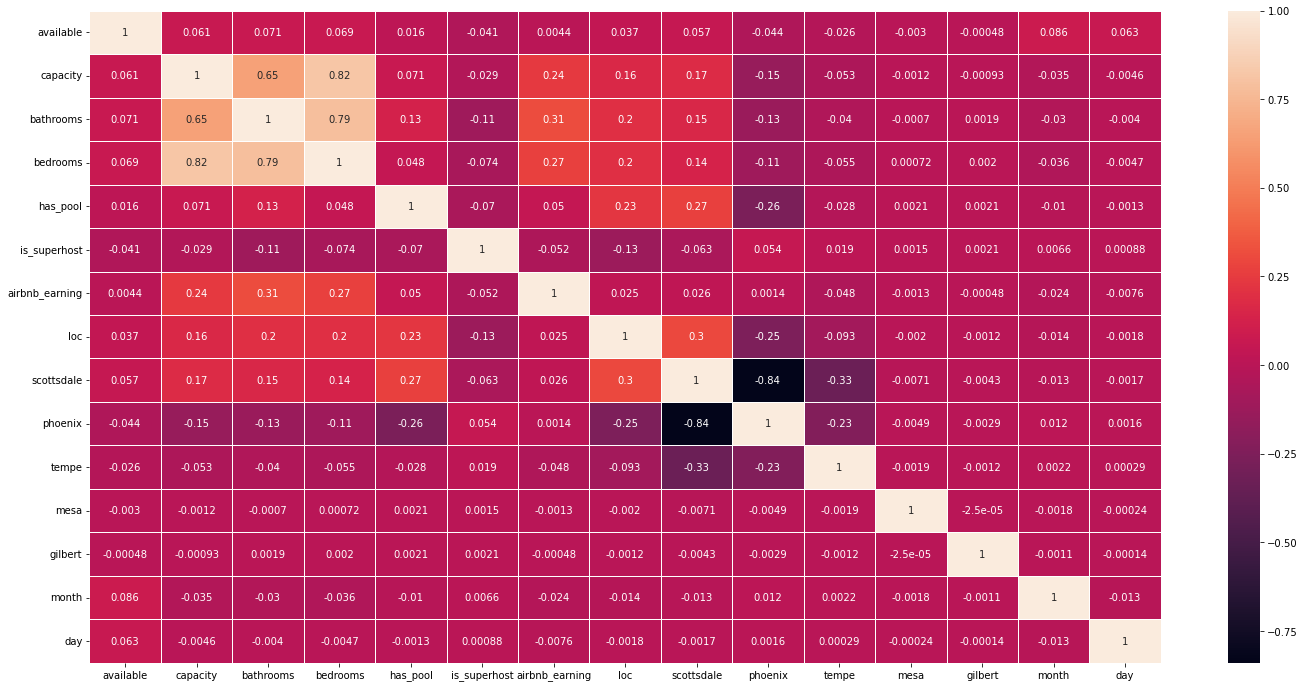

In [ ]:
plt.figure(figsize = (24, 12))

corr = data.corr()
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

In [ ]:
X=data.iloc[:,1:]
y=data['available'].astype(np.uint8)

## Splitting the dataset and the scaling the numerical variables

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10)

In [ ]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

## Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
conf = confusion_matrix(y_test, y_pred_lr)
clf_report = classification_report(y_test, y_pred_lr)

print(f"Accuracy Score of Logistic Regression is : {acc_lr}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Logistic Regression is : 0.5581465971541418
Confusion Matrix : 
[[511746 323377]
 [396852 398043]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.56      0.61      0.59    835123
           1       0.55      0.50      0.53    794895

    accuracy                           0.56   1630018
   macro avg       0.56      0.56      0.56   1630018
weighted avg       0.56      0.56      0.56   1630018



## KNN

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
conf = confusion_matrix(y_test, y_pred_knn)
clf_report = classification_report(y_test, y_pred_knn)

print(f"Accuracy Score of KNN is : {acc_knn}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of KNN is : 0.910440866297182
Confusion Matrix : 
[[763672  71451]
 [ 74532 720363]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.91      0.91      0.91    835123
           1       0.91      0.91      0.91    794895

    accuracy                           0.91   1630018
   macro avg       0.91      0.91      0.91   1630018
weighted avg       0.91      0.91      0.91   1630018



## Decision Tree

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
conf = confusion_matrix(y_test, y_pred_dtc)
clf_report = classification_report(y_test, y_pred_dtc)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Decision Tree is : 0.9204284860657981
Confusion Matrix : 
[[776369  58754]
 [ 70949 723946]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.93      0.92    835123
           1       0.92      0.91      0.92    794895

    accuracy                           0.92   1630018
   macro avg       0.92      0.92      0.92   1630018
weighted avg       0.92      0.92      0.92   1630018



## Random Forest

In [ ]:
rd_clf = RandomForestClassifier()
rd_clf.fit(X_train, y_train)

y_pred_rd_clf = rd_clf.predict(X_test)

acc_rd_clf = accuracy_score(y_test, y_pred_rd_clf)
conf = confusion_matrix(y_test, y_pred_rd_clf)
clf_report = classification_report(y_test, y_pred_rd_clf)

print(f"Accuracy Score of Random Forest is : {acc_rd_clf}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Random Forest is : 0.9205082397863091
Confusion Matrix : 
[[775221  59902]
 [ 69671 725224]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.93      0.92    835123
           1       0.92      0.91      0.92    794895

    accuracy                           0.92   1630018
   macro avg       0.92      0.92      0.92   1630018
weighted avg       0.92      0.92      0.92   1630018



## Adaboost

In [ ]:
ada = AdaBoostClassifier(base_estimator = dtc)
ada.fit(X_train, y_train)

y_pred_ada = ada.predict(X_test)

acc_ada = accuracy_score(y_test, y_pred_ada)
conf = confusion_matrix(y_test, y_pred_ada)
clf_report = classification_report(y_test, y_pred_ada)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_ada}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.9203800203433337
Confusion Matrix : 
[[775422  59701]
 [ 70081 724814]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.93      0.92    835123
           1       0.92      0.91      0.92    794895

    accuracy                           0.92   1630018
   macro avg       0.92      0.92      0.92   1630018
weighted avg       0.92      0.92      0.92   1630018



## Gradient Boosting

In [ ]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb)
conf = confusion_matrix(y_test, y_pred_gb)
clf_report = classification_report(y_test, y_pred_gb)

print(f"Accuracy Score of Gradient Boost Classifier is : {acc_gb}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Gradient Boost Classifier is : 0.6088736443401238
Confusion Matrix : 
[[479250 355873]
 [281670 513225]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.63      0.57      0.60    835123
           1       0.59      0.65      0.62    794895

    accuracy                           0.61   1630018
   macro avg       0.61      0.61      0.61   1630018
weighted avg       0.61      0.61      0.61   1630018



## XGBoost

In [ ]:
xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
conf = confusion_matrix(y_test, y_pred_xgb)
clf_report = classification_report(y_test, y_pred_xgb)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_xgb}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.6749422399016453
Confusion Matrix : 
[[536243 298880]
 [230970 563925]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.70      0.64      0.67    835123
           1       0.65      0.71      0.68    794895

    accuracy                           0.67   1630018
   macro avg       0.68      0.68      0.67   1630018
weighted avg       0.68      0.67      0.67   1630018



## Voting Classifier

In [ ]:
classifiers = [('Gradient Boosting Classifier', gb), ('XGboost', xgb),  ('Decision Tree', dtc), ('Random Forest', rd_clf), ('Ada Boost', ada), ('Logistic', lr),
               ('Knn', knn)]
vc = VotingClassifier(estimators = classifiers)
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('Gradient Boosting Classifier',
                              GradientBoostingClassifier()),
                             ('XGboost',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None...
                                            monotone_constraints='()',
                                            n_estimators=180, n_jobs=0,
                                            n

In [ ]:
y_pred_vc = vc.predict(X_test)

acc_vtc = accuracy_score(y_test, y_pred_vc)
conf = confusion_matrix(y_test, y_pred_vc)
clf_report = classification_report(y_test, y_pred_vc)

print(f"Accuracy Score of Voting Classifier is : {acc_vtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Voting Classifier is : 0.9176045908695487
Confusion Matrix : 
[[771814  63309]
 [ 70997 723898]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.92      0.92    835123
           1       0.92      0.91      0.92    794895

    accuracy                           0.92   1630018
   macro avg       0.92      0.92      0.92   1630018
weighted avg       0.92      0.92      0.92   1630018



## Model Comparison

In [ ]:
models = pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decision Tree Classifier', 'Random Forest Classifier','Ada Boost Classifier',
             'Gradient Boosting Classifier', 'XgBoost', 'Voting Classifier'],
    'Score' : [acc_lr, acc_knn, acc_dtc, acc_rd_clf, acc_ada, acc_gb, acc_xgb, acc_vtc]
})


models.sort_values(by = 'Score', ascending = False)

,Model,Score
3,Random Forest Classifier,0.920508
2,Decision Tree Classifier,0.920428
4,Ada Boost Classifier,0.920380
7,Voting Classifier,0.917605
1,KNN,0.910441
6,XgBoost,0.674942
5,Gradient Boosting Classifier,0.608874
0,Logistic Regression,0.558147


In [ ]:
import plotly.express as px
px.bar(data_frame = models, x = 'Score', y = 'Model', color = 'Score', template = 'plotly_dark', title = 'Models Comparison')

## Feature Importance

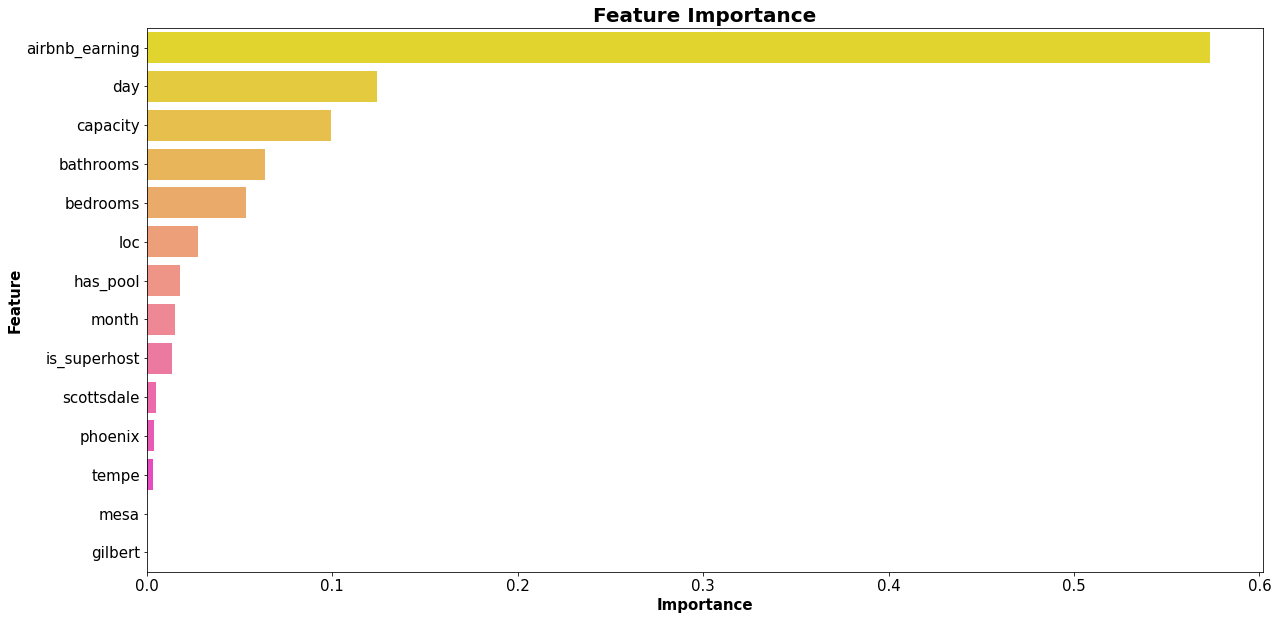

In [ ]:
fi = pd.DataFrame(rd_clf.feature_importances_,columns=['importance'])
fi['feature'] = ['capacity', 'bathrooms', 'bedrooms', 'has_pool',
       'is_superhost', 'airbnb_earning', 'loc', 'scottsdale', 'phoenix',
       'tempe', 'mesa', 'gilbert', 'month', 'day']
fi = fi.sort_values('importance', ascending=False)

plt.figure(figsize=(20, 10))
ax = sns.barplot(data=fi, x='importance', y='feature',
                 palette="spring_r")
ax.tick_params(axis='both', which='both', labelsize=15)
ax.set_xlabel('Importance',fontsize=15, weight="bold");
ax.set_ylabel('Feature',fontsize=15,weight="bold");
plt.title("Feature Importance", size=20, weight="bold");